# Quantitative and visual exploratory data analysis (EDA)<br> 
### by Ori Rosenthal

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import squarify 
from adjustText import adjust_text
from IPython.display import Image
import datetime
from time import sleep
from time import strftime
from geopy.geocoders import Nominatim
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnchoredText
import matplotlib.patheffects as path_effects
import matplotlib.patches as mpatches
import mplcyberpunk

%matplotlib inline

import os
os.environ['PROJ_LIB'] = r'C:\Users\User\Anaconda3\envs\data_env\Library\share'
from mpl_toolkits.basemap import Basemap
import folium
pd.options.display.max_rows = 999


![covid image](https://cdn3.creativecirclemedia.com/wilsontimes/original/20200315-135549-COVID19%20GRAPHICweb.jpg)
Image from cdn3.creativecirclemedia.com

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<u><b>Notes:</b></u><br> 
This notebook presents an exploratory data analysis, for coronavirus pandemic, particularly with advanced visualization.<br>
In order to make it more clearly visible, I have hidden the prompt code from this version.<br>
The full code can be found in my GitHub: <div style="direction:ltr"><a href="https://github.com/Orosenthal/COVID19-eda">COVID19-eda</a></div>
    

The data was extracted from these three sources:
1. <div style="direction:rtl">
    <a href="https://www.worldometers.info/coronavirus/">Worldometers</a>
</div> 
2. <div style="direction:rtl">
    <a href="https://github.com/COVID19Tracking/covid-tracking-data/">COVID Tracking Data</a>
</div> 
3. <div style="direction:rtl">
    <a href="https://en.wikipedia.org/wiki/List_of_countries_by_dependency_ratio/">wikipedia</a>
</div> 
  


In [2]:
print(f'Last update of data sets: {datetime.datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")} (UTC)')

Last update of data sets: 2020-05-26 15:52:15 (UTC)


In [3]:
def get_lat_lon(location):
    '''
    get longitude and latitude from geolocator api
    '''
    geolocator = Nominatim(user_agent="data_covid")
    location = geolocator.geocode(location)
    return(location.longitude, location.latitude)   



def plot_stacked_pct():
    
    
    plt.style.use('seaborn-deep')
    df_pct = df[df['TotalCases'] > 5000][['ActiveCases','TotalRecovered','TotalDeaths']]
    df_pct = (df_pct.T/df_pct.T.sum()*100).T.round(2)
    df_pct = df_pct.sort_values(by='ActiveCases')
    df_pct.plot.barh(stacked=True, figsize=(17,15));
    plt.yticks(fontsize=15);plt.margins(x=0,y=0);plt.grid(b=None);plt.xticks([], []);plt.ylabel("");
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0),ncol=3);
    plt.title(f'Current status: Active, Recovered, Deathes ({datetime.date.today()})', fontsize=25);
    
    
    
def plot_20cq(by='worst_cases', boxes=20):
    

    if by == 'worst_cases':
        
        title_label = 'Most infected countries by absolute figures'
        main_column = 'TotalCases'
        minmax = 'TotalCases'
        ps = df[[main_column]].sort_values(by=main_column,ascending=False).head(boxes)
        ps['Label'] = ps.index + "\n" + ps[main_column].apply(lambda x : "{:,}".format(x))
        cmap = matplotlib.cm.jet
        
    elif by =='mortality_rate':
        
        title_label = 'Worst countries by case fatality ratios'
        main_column = 'TotalCases'
        minmax = 'Deaths/Cases'
        ps = df[df[main_column] > 1000][[minmax]].sort_values(by=minmax,ascending=False).head(boxes).round(3)
        ps ['Label'] = ps.index + "\n" + ps[minmax].apply(lambda x : "{:.1%}".format(x))
        cmap = matplotlib.cm.Reds
        
    elif by == 'recovery_rate':
        
        title_label = 'countries with the highest recovery rate'
        main_column = 'TotalCases'
        minmax = 'Recovered/Cases'
        ps = df[df[main_column] > 1000][[minmax]].sort_values(by=minmax,ascending=False).head(boxes).round(3)
        ps ['Label'] = ps.index + "\n" + ps[minmax].apply(lambda x : "{:.1%}".format(x))
        cmap = matplotlib.cm.Greens
        
    elif by == 'test_rate':
        
        title_label = 'Countries with the highest test rate per 1 million'
        main_column = 'TotalCases'
        minmax = 'Tests/1Mpop'
        ps = df[(df[main_column] > 1000) & ((df['Population(2020)']>5_000_000))][[minmax]].sort_values\
        (by=minmax,ascending=False).head(boxes).round(3)
        ps[minmax] = ps[minmax].astype(int)
        ps ['Label'] = ps.index + "\n" + ps[minmax].apply(lambda x : "{:,}".format(x))   
        cmap = matplotlib.cm.Blues
        
    elif by == 'us_worst_cases':
        
        title_label = 'Most infected states by absolute figures'
        main_column = 'positive'
        minmax = 'positive'
        ps = usa_covid19.groupby('state').first()[[minmax]].sort_values(by='positive',ascending=False).head(boxes)
        ps ['Label'] = ps.index + "\n" + ps['positive'].apply(lambda x : "{:,}".format(x))
        ps = ps[ps['positive'] > 0]
        cmap = matplotlib.cm.jet
        


    plt.figure(figsize=(16,10))
    plt.axis('off')
    mini = min(ps[minmax])
    maxi = max(ps[minmax])
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in ps[minmax]]
    squarify.plot(ps[minmax], label=ps['Label'],color=colors, alpha=0.6,pad=True,
                  text_kwargs={'fontsize':14});
    plt.title(f'{boxes} {title_label}', pad=20,fontsize=30);



def pair_corr_plot(df, tc_threshold = 10000, x ='MedAg', y='Deaths/Cases'):

    plt.style.use('bmh')
    fig, ax = plt.subplots(figsize = (16, 10))
    df_age = df[df['TotalCases']>tc_threshold].reset_index().sort_values(x, ascending=False)
    df_age['Deaths/Cases'] = df_age['TotalDeaths'] / df_age['TotalCases']
    corr = df_age[x].corr(df_age[y]).round(3)
    sns.regplot(x, y, data=df_age, label='Country');
    text = [plt.text(x, y, z, color='r', size=15) for x, y, z in zip(df_age[x],df_age[y],df_age['Country'])]
    plt.title(f'COVID19 - Countries by {x} Vs. {y}',pad=15,weight = 'semibold')
    sns.set(font_scale=1.4);
    anchored_text = AnchoredText(f"Correlation: {corr}", loc=2,prop=dict(fontweight="bold"))
    ax.add_artist(anchored_text);
    adjust_text(text);
    
    
def countries_tpr_recovery():
    

    fig, ax = plt.subplots(figsize = (20, 14))
    df_ir = df[(df['Tests/1Mpop'] > 5000) & (df['TotalCases']>5000)].reset_index()
    df_ir['recoverd\cases'] = df_ir['TotalRecovered'] / (df_ir['TotalCases'] - df_ir['TotalDeaths'])
    df_ir['Cases_tests_recoverd_retio'] = df_ir['recoverd\cases'] * df_ir['Cases/Test']
    df_ir = df_ir.sort_values(by='Cases/Test')
    median_ir = df_ir['Cases/Test'].median()
    ax = sns.barplot(x= "Cases/Test", y = "Country", data = df_ir, palette=("OrRd"), label='Test positivity rate (cases/tests)')
    ax2 = sns.barplot(x= "Cases_tests_recoverd_retio", y = "Country", data = df_ir, color='g', label='Current Recovery rate')
    plt.title(f'COVID19 - Confirmed cases (Test positive rate) & Recovery Rate by Countries ({datetime.date.today()})',
              fontsize=20,pad=12,weight ='semibold')
    ax3 = plt.axvline(median_ir, linestyle='--', c='grey', alpha=0.7,
                      label=f'Median positivity rate: {np.round(median_ir*100,2)}%')
    plt.gca().legend(prop={'size': 20})
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    plt.yticks(fontsize=20); plt.xlabel('Test positive rate')
    leg = ax.get_legend()
    leg.legendHandles[1].set_color('brown'); sns.set_context("poster");
    
    
def countries_cases_recovery():
    

    fig, ax = plt.subplots(figsize = (20, 14))
    df_ir = df[df['TotalCases']>10000].reset_index()
    df_ir['recoverd/1M'] = df_ir['TotalRecovered'] / (df_ir['Population(2020)'] /1_000_000) 
    df_ir = df_ir.sort_values(by='TotCases_1M')
    ax = sns.barplot(x= "TotCases_1M", y = "Country", data = df_ir, palette=("OrRd"), label='Cases per million')
    ax2 = sns.barplot(x= "recoverd/1M", y = "Country", data = df_ir, color='g', label='Recovery per million')
    plt.title(f'COVID19 - Confirmed Cases & Recovery per million by Countries ({datetime.date.today()})',
              fontsize=20,pad=12,weight ='semibold')
    ax3 = plt.axvline(df_ir['TotCases_1M'].median(), linestyle='--', c='r', alpha=0.8,
                      label=f'Median cases per million: {df_ir["TotCases_1M"].median():,}')
    ax4 = plt.axvline(df_ir['recoverd/1M'].median(), linestyle='--', c='g', alpha=0.8,
                      label=f'Median recovery per million: {np.round(df_ir["recoverd/1M"].median())}')
    plt.gca().legend(prop={'size': 20})
    plt.yticks(fontsize=20); plt.xlabel('Cases per Million')
    leg = ax.get_legend()
    leg.legendHandles[2].set_color('brown'); sns.set_context("poster");
    
    
    
def countries_tpr_tr():
    
    
    fig, ax = plt.subplots(figsize = (15, 10))
    df_ir = df[df['TotalCases']>10000].reset_index()
    df_ir = df_ir.sort_values(by='Tests/1Mpop')
    ax = sns.barplot(x= "Country" , y = "Tests/1Mpop", data = df_ir, color='g', label='Test per million')
    plt.xticks(rotation=70, fontsize=15); 
    plt.yticks(color='blue', size=20)
    ax2 = ax.twinx()
    ax2 = sns.pointplot(x= "Country", y = "Cases/Test", data = df_ir, color='r', label='Tests positivity rate')
    ax.yaxis.set_ticks_position("right")
    ax2.yaxis.set_ticks_position("left")
    ax.set_ylabel('Test Poitive Rate (%)', fontsize=16, color='red', size=20,labelpad=35)
    ax2.set_ylabel('Tests per Million', fontsize=16, color='green', size=20, rotation=270, labelpad=60)
    ax.set_ylabel('Test Poitive Rate (%)', fontsize=16, color='red', size=20,labelpad=50)
    ax2.set_ylabel('Tests per Million', fontsize=16, color='green', size=20, rotation=270, labelpad=60)
    plt.title(f'COVID19 - Test positive rate Vs Test per million',fontsize=25,pad=12,weight ='semibold');
    ax.tick_params(axis='y', color='r', labelsize=10)
    plt.yticks(color='red', size=15);ax2.grid(False);
    

def worst_countries():

    
    import matplotlib.patheffects as path_effects
    worst_countries = df[df['Population(2020)']>1_000_000].sort_values('Deaths/1Mpop',ascending=False)
    worst_countries = worst_countries.head(round(0.1 * len(worst_countries)))

    median_cases = worst_countries['TotCases_1M'].median()
    median_deaths = worst_countries['Deaths/1Mpop'].median()
    fig, ax = plt.subplots(figsize=(16,9), dpi= 80)
    sns.scatterplot(x='TotCases_1M', y='Deaths/1Mpop', data=worst_countries, s=40, color='darkblue');
    text = [plt.text(x, y, z, color='w', size=20,path_effects=[path_effects.Stroke(linewidth=3,
        foreground='darkblue'), path_effects.Normal()]) \
            for x, y, z in zip(worst_countries['TotCases_1M'], worst_countries['Deaths/1Mpop'],worst_countries.index)]
    plt.title(f'COVID19 - Worst hit countries Cases Vs. Deaths per 1M \n(top 10% countries with the highest death'\
              'rate per million)', color='dimgray', pad=15,fontsize=17, weight = 'semibold')
    ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
    plt.margins(x=0,y=0)
    ax.patch.set_facecolor('red');ax.patch.set_alpha(0.6);
    ax.grid(False)
    sns.set(font_scale = 1.5);
    ax.tick_params( colors='dimgray')
    adjust_text(text);
    

def us_cases_ts():
    
    
    usa_positive = usa_covid19.groupby('date')[['positive','positiveIncrease']].sum()
    usa_positive = usa_positive[usa_positive.index >= '2020-03-01'].reset_index()
    plt.style.use('seaborn-deep')
    fig, ax = plt.subplots(figsize=(16,9))
    plt.bar(usa_positive['date'], height=usa_positive['positiveIncrease'], width=0.9);
    plt.xticks(fontsize=17,rotation=45);
    plt.yticks(color='blue', size=20)
    plt.xlim(usa_positive['date'].min().date(),usa_positive['date'].max().date()+ datetime.timedelta(2))
    plt.title(f"COVID19 - Cases in United States: { usa_positive[-1:]['positive'].values[0]:,}", fontsize=25,pad=15,
              weight ='semibold')
    ax.set_ylabel('Daily Positive Increase', fontsize=16, color='blue', size=20,rotation=360)
    ax.yaxis.set_label_coords(-0.05,1.04)

    ax2 = ax.twinx()
    plt.plot(usa_positive['date'],usa_positive['positive'], lw=3.5, color='r', marker='.', markersize=20 )
    plt.yticks(color='red', size=20)
    plt.ylim(0,(usa_positive['positive'].max()*1.2))
    ax2.set_ylabel('Total Positive Cases', fontsize=16, color='red', size=20, rotation=360, labelpad=35)
    ax2.yaxis.set_label_coords(+1.05,1.08)
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))); 
    ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))));
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3));
    ax.grid(False);ax2.grid(False)

    
def us_cases_ts_gr():  
    
    '''
    us cumulative cases time series with growth rate
    
    '''
    plt.style.use('default')
    usa_positive = usa_covid19.groupby('date')[['positive','positiveIncrease']].sum()
    usa_positive['gr'] = usa_positive['positive'].pct_change()
    usa_positive['gr_ma3'] = usa_positive['gr'].rolling(3).mean()
    usa_positive = usa_positive[usa_positive.index >= '2020-03-15']
    plt.style.use('seaborn-deep')
    fig, ax = plt.subplots(figsize=(16,9))
    ax.plot(usa_positive.index,usa_positive['gr_ma3'], color='navy');
    plt.xticks(fontsize=17,rotation=45);
    plt.yticks(color='navy', size=20)
    plt.xlim(usa_positive.index.min().date(),usa_positive.index.max().date()+ datetime.timedelta(3))
    plt.title(f"COVID19 ({usa_positive.index[-1].date()}) - Cases in US:  { int(usa_positive[-1:]['positive'].values[0]):,}",
              fontsize=25,pad=15, weight ='semibold')
    ax.set_ylabel('Growth rate %', fontsize=16, color='navy', size=20,rotation=360)
    ax.yaxis.set_label_coords(0,1.04);mplcyberpunk.add_glow_effects(ax);
    text = [plt.text(x, y, round(z,3), color='navy', size=20) for x, y, z in zip(usa_positive.index[-2:],
            usa_positive[-1:]['gr_ma3']*1.3,usa_positive[-1:]['gr_ma3'])]
    ax2 = ax.twinx()
    ax2.plot(usa_positive.index,usa_positive['positive'], lw=3.5, color='r', marker='.', markersize=15 )
    plt.yticks(color='red', size=20)
    plt.ylim(0,(usa_positive['positive'].max()*1.2))
    ax2.set_ylabel('Total Positive Cases', fontsize=16, color='red', size=20, rotation=360, labelpad=35)
    ax2.yaxis.set_label_coords(+1.05,1.08);mplcyberpunk.add_glow_effects(ax2);
    ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))));
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3));
    plt.grid(b=None);plt.minorticks_off();
    
def us_positive_t20():
    

    fig, ax = plt.subplots(figsize = (18, 14))
    ax = sns.barplot(x="positive",y="state",data=usa_covid19.groupby('state')[['positive']].first()\
            .sort_values(by='positive').reset_index()[-20:],palette=("OrRd"), label='Current Cases'); 
    ax2 = sns.barplot(x="positive",y="state",data=usa_covid19lw.groupby('state')[['positive']].first()\
            .sort_values(by='positive').reset_index()[-20:],palette=("GnBu"), label='7 Days ago'); 
    plt.yticks(fontsize=20); plt.xticks(fontsize=20);
    ax.set_xlabel("Positive Cases",fontsize=20, color='gray', weight ='semibold')
    ax.set_ylabel("States",fontsize=20, color='gray',weight ='semibold')
    plt.title(f'COVID19 - US - Top 20 Most Infected States (last update: {usa_covid19.date[0].date()})',
          fontsize=20, weight ='semibold');
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))));
    plt.gca().legend(prop={'size': 20}); leg = ax.get_legend()
    leg.legendHandles[0].set_color('brown');leg.legendHandles[1].set_color('royalblue'); sns.set_context("poster");


def us_top5_s_cumulative():
    
    
    
    plt.style.use("cyberpunk")
    usa_tspc = usa_covid19[(usa_covid19['date'] > '2020-03-01') & (usa_covid19['state'].isin(usa_t5.index.tolist()))]\
               .pivot_table(index='date',values='positive', columns='state')
    agr = (usa_tspc.pct_change().rolling(3).mean()[-1:]*100).T
    ax = usa_tspc.plot(figsize=(10,7), lw=2.5)
    ax.legend(loc=0, prop={'size': 14})
    patch = [mpatches.Patch(color=ax.get_lines()[i].get_color(),
             label=f'{usa_tspc.columns[i]}, growth rate: {np.round(agr.iloc[i][0],2)}%') for i in range(len(agr))]
    [ha.set_linewidth(0.5) for ha in patch]
    ax.legend(handles=patch,loc=2,fontsize=14)
    plt.xlim(usa_tspc.index.min(), usa_tspc.index.max() + datetime.timedelta(5))
    plt.ylim(0,usa_tspc.max().max()*1.1)
    mplcyberpunk.make_lines_glow(ax)
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x/10**3:,.0f}K'))
    ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%b-%d'));
    ax.get_xaxis().set_major_locator(mdates.DayLocator(interval=10));
    ax.xaxis.label.set_visible(False);plt.minorticks_off();plt.xticks(fontsize=14);plt.yticks(fontsize=14);
    plt.title(f'Covid19 - US Top States Cumulative Cases By Date (update: {usa_covid19.date[0].date()})',
              fontname='Comic Sans MS', fontsize=15,weight ='semibold');


    
def positive_cases_plot(df,state):
    
    state_c = df[df['state'] ==state][['date','positiveIncrease','deathIncrease']].sort_values(by='date')\
    .reset_index(drop=True).dropna()
    state_c['total_cases'] = state_c['positiveIncrease'].cumsum()
    plt.style.use('seaborn-deep')
    fig, ax = plt.subplots(figsize=(16,5))
    plt.bar(state_c['date'], height=state_c['positiveIncrease'], width=0.9,alpha=0.9);
    plt.xlim(state_c['date'].min().date(),state_c['date'].max().date() + datetime.timedelta(2))
    plt.xticks(fontsize=17,rotation=45);
    plt.yticks(color='blue', size=20)
    plt.margins(x=0.04)
    plt.title(f'COVID19 - Cases in {state}', fontsize=25,pad=15,weight ='semibold')
    ax.set_ylabel('Daily Positive Increase', fontsize=16, color='blue', size=20,rotation=360)
    ax.yaxis.set_label_coords(-0.05,1.04)
    ax.grid(False)
    ax2 = ax.twinx()
    plt.plot(state_c['date'],state_c['total_cases'], lw=3.5, color='r', marker='.', markersize=20)
    plt.yticks(color='red', size=20); ax2.grid(False)
    ax2.set_ylabel('Total Positive Cases', fontsize=16, color='red', size=20, rotation=360, labelpad=35)
    ax2.yaxis.set_label_coords(+1.05,1.1)
    at = AnchoredText(f"Total Positive Cases: {int(state_c['total_cases'].iloc[-1]):,}",
                  prop=dict(size=15, color='r',fontweight="bold"), frameon=True, loc='upper left',)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))); 
    ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))));
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))    
    
    
def test_positive_rate_plot():
    
    
    usa_test = usa_covid19.groupby('date')[['positiveIncrease','totalTestResultsIncrease']].sum()
    usa_test = usa_test[usa_test.index >= '2020-03-01'].reset_index()
    usa_test['tpr'] = usa_test['positiveIncrease'] / usa_test['totalTestResultsIncrease']
    usa_tpr_ma = usa_test['tpr'].rolling(5).mean()
    plt.style.use('seaborn-deep')
    fig, ax = plt.subplots(figsize=(16,9))
    plt.bar(usa_test['date'], height=usa_test['totalTestResultsIncrease'], width=0.9,
            color='grey',label='US Daily total tests');
    plt.bar(usa_test['date'], height=usa_test['positiveIncrease'],color='r', width=0.9, label='US Daily positive tests')
    plt.xticks(fontsize=17,rotation=45);
    plt.yticks(color='grey', size=20)
    ax.set_ylabel('Daily Tests', fontsize=16, color='blue', size=20,rotation=360)
    ax.yaxis.set_label_coords(-0.05,1.04)

    ax2 = ax.twinx()
    plt.plot(usa_test['date'], usa_tpr_ma, lw=3.5, color='black', label='Test positive rate\n5-day moving average')
    plt.yticks(color='red', size=20)
    ax2.set_ylabel('Test Positive Rate', fontsize=16, color='red', size=20, rotation=360, labelpad=35)
    ax2.yaxis.set_label_coords(+1.05,1.08)
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))); 
    ax2.set_yticklabels(['{:,.0%}'.format(x) for x in ax2.get_yticks()])
    ax.grid(False);ax2.grid(False);
    ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.1),ncol=3);
    ax2.legend(loc='upper center', bbox_to_anchor=(0.25, 1.1),ncol=3);
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3));



def positive_cases_plot(df,state):
    
    
    plt.style.use('seaborn-deep')
    state_c = df[df['state'] ==state][['date','positiveIncrease','deathIncrease']].sort_values(by='date')\
    .reset_index(drop=True).dropna()
    state_c['total_cases'] = state_c['positiveIncrease'].cumsum()
    plt.style.use('seaborn-deep')
    fig, ax = plt.subplots(figsize=(16,5))
    plt.bar(state_c['date'], height=state_c['positiveIncrease'], width=0.9,alpha=0.9);
    plt.xlim(state_c['date'].min().date(),state_c['date'].max().date() + datetime.timedelta(2))
    plt.xticks(fontsize=17,rotation=45);
    plt.yticks(color='blue', size=20)
    plt.margins(x=0.04)
    plt.title(f'COVID19 - Cases in {state}', fontsize=25,pad=15,weight ='semibold')
    ax.set_ylabel('Daily Positive Increase', fontsize=16, color='blue', size=20,rotation=360)
    ax.yaxis.set_label_coords(-0.05,1.04)
    ax.grid(False)
    

    ax2 = ax.twinx()
    plt.plot(state_c['date'],state_c['total_cases'], lw=3.5, color='r', marker='.', markersize=20)
    plt.yticks(color='red', size=20); ax2.grid(False)
    ax2.set_ylabel('Total Positive Cases', fontsize=16, color='red', size=20, rotation=360, labelpad=35)
    ax2.yaxis.set_label_coords(+1.05,1.1)
    at = AnchoredText(f"Total Positive Cases: {int(state_c['total_cases'].iloc[-1]):,}",
                  prop=dict(size=15, color='r',fontweight="bold"), frameon=True, loc='upper left',)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))); 
    ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))));
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
    
    
def top_20_infected():
    

    usa_covid19l_pc = usa_covid19.groupby('state')[['positive']].first().sort_values(by='positive')[-20:]
    usa_covid19l_pc['last_week'] = usa_covid19[usa_covid19['date']<(usa_covid19.date.max()-datetime.timedelta(6))]\
                  .groupby('state')[['positive']].first().sort_values(by='positive')
    fig, ax = plt.subplots(figsize = (18, 14))
    ax = sns.barplot(x="positive",y=usa_covid19l_pc.index,data=usa_covid19l_pc,palette=("OrRd"), label='Cumulative Cases'); 
    ax2 = sns.barplot(x="last_week",y=usa_covid19l_pc.index,data=usa_covid19l_pc, palette=("GnBu"), label='7 Days ago'); 
    plt.yticks(fontsize=20); plt.xticks(fontsize=20);
    ax.set_xlabel("Positive Cases",fontsize=20, color='gray', weight ='semibold')
    ax.set_ylabel("States",fontsize=20, color='gray',weight ='semibold')
    plt.title(f'COVID19 - US - Top 20 Infected States (last update: {usa_covid19.date[0].date()})',fontsize=20,
          weight ='semibold');
    text = [plt.text(y+2000, x, "{:,}".format(int(y)),color='w', size=17,
                 path_effects=[path_effects.withSimplePatchShadow()]) for x, y in enumerate(usa_covid19l_pc['positive'])]
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))));
    plt.xlim(0, usa_top20['positive'].max()*1.1);plt.gca().legend(prop={'size': 20}); leg = ax.get_legend()
    leg.legendHandles[0].set_color('brown');leg.legendHandles[1].set_color('royalblue'); sns.set_context("poster");

In [4]:
import requests

url = 'https://www.worldometers.info/coronavirus/#countries'
url2 = 'https://www.worldometers.info/world-population/population-by-country/'
url3 = 'https://github.com/COVID19Tracking/covid-tracking-data/raw/master/data/states_daily_4pm_et.csv'
url4 = 'https://en.wikipedia.org/wiki/OECD'
r1 = requests.get(url)
r2 = requests.get(url2)

a = pd.read_html(r1.text)[0]
b = pd.read_html(r2.text)[0]
usa_covid19 = pd.read_csv(url3, parse_dates=['date'])
oecd_countries = pd.read_html(url4)[5]['Country'].to_list()

In [5]:
# Main data table from www.worldometers
a.head()

# Country,Other  TotalCases NewCases  TotalDeaths NewDeaths  \
0  NaN         World     5631831  +47,564     349052.0    +1,439   
1  1.0           USA     1710558   +4,332      99930.0      +125   
2  2.0        Brazil      376669      NaN      23606.0       +84   
3  3.0        Russia      362342   +8,915       3807.0      +174   
4  4.0         Spain      282480      NaN      26837.0       NaN   

   TotalRecovered  ActiveCases  Serious,Critical  Tot Cases/1M pop  \
0       2399258.0    2883521.0           53161.0             723.0   
1        466980.0    1143648.0           17114.0            5171.0   
2        153833.0     199230.0            8318.0            1773.0   
3        131129.0     227406.0            2300.0            2483.0   
4        196958.0      58685.0             854.0            6042.0   

   Deaths/1M pop  TotalTests  Tests/ 1M pop   Population  
0           44.8         NaN            NaN          NaN  
1          302.0  15235274.0        46054.0  330811717.0  
2          111.0    735224.0         3461.0  212409786.0  
3           26.0   9160590.0        62775.0  145928485.0  
4          574.0   3556567.0        76071.0   46753049.0

In [6]:
# Secondary table from www.worldometers with features on each country
b.head()

# Country (or dependency)  Population (2020) Yearly Change  Net Change  \
0  1                   China         1439323776        0.39 %     5540090   
1  2                   India         1380004385        0.99 %    13586631   
2  3           United States          331002651        0.59 %     1937734   
3  4               Indonesia          273523615        1.07 %     2898047   
4  5                Pakistan          220892340        2.00 %     4327022   

   Density (P/Km²)  Land Area (Km²)  Migrants (net) Fert. Rate Med. Age  \
0              153          9388211       -348399.0        1.7       38   
1              464          2973190       -532687.0        2.2       28   
2               36          9147420        954806.0        1.8       38   
3              151          1811570        -98955.0        2.3       30   
4              287           770880       -233379.0        3.6       23   

  Urban Pop % World Share  
0        61 %     18.47 %  
1        35 %     17.70 %  
2        83 %      4.25 %  
3        56 %      3.51 %  
4        35 %      2.83 %

<!-- <u><b>Note</b></u>: Our main data table for corona virus world data is table <b>a</b>, I download table <b>b</b> also to add some different features to the countries (median age, urban population. etc..). Now, since we're going to merge the two data frames together, we need to check if we have the same country name and the same column name. -->

In [7]:
# Fix columns name
a.rename(columns={'Country,Other':'Country',
                  "Tot Cases/1M pop":"TotCases_1M pop",
                  "Tot Deaths/1Mpop":"Tot Deaths_1M pop",
                  "Serious,Critical":"Serious",
                  "Tot\xa0Cases/1M pop":"TotCases_1M"}, inplace=True)

b.rename(columns={'Country (or dependency)':'Country', 'Med. Age':'MedAg'}, inplace=True)

b = b[b['Country'] !='Congo']

# Replace (from DataFrame above) country names with a dictionary before joining together 
b.Country.replace({'United Arab Emirates':'UAE', "Côte d'Ivoire": 'Ivory Coast', 'DR Congo':'Congo',
                   'State of Palestine':'Palestine','Central African Republic':'CAR',
                   'Sao Tome & Principe':'Sao Tome and Principe','St. Vincent & Grenadines':'St. Vincent Grenadines',
                   'Saint Kitts & Nevis':'Saint Kitts and Nevis','Saint Barthelemy':'St. Barth',
                   'Saint Pierre & Miquelon': 'Saint Pierre Miquelon', 'Czech Republic (Czechia)':'Czech Republic',
                  }, inplace= True)
a.Country.replace({'USA':'United States','UK':'United Kingdom', 'S. Korea':'South Korea', 'Czechia':'Czech Republic'},
                 inplace=True)
# 'Diamond Princess' and 'MS Zaandam' are cruise ships, Vatican City wasnt found on DataSet b,
# They will be removed from the df merge later, with 'world' (which is an aggregation row), 
# and also China due to the circulation of false Chinese data

In [8]:
# merge a and b to one data set
df = a.merge(b, on='Country')

In [9]:
df.columns

Index(['#_x', 'Country', 'TotalCases', 'NewCases', 'TotalDeaths', 'NewDeaths',
       'TotalRecovered', 'ActiveCases', 'Serious', 'TotCases_1M',
       'Deaths/1M pop', 'TotalTests', 'Tests/ 1M pop', 'Population', '#_y',
       'Population (2020)', 'Yearly Change', 'Net Change', 'Density (P/Km²)',
       'Land Area (Km²)', 'Migrants (net)', 'Fert. Rate', 'MedAg',
       'Urban Pop %', 'World Share'],
      dtype='object')

In [10]:
df.drop(['#_x','#_y','Yearly Change','NewDeaths','Migrants (net)','Land Area (Km²)','World Share','Net Change',
         'Land Area (Km²)'],
        axis=1, inplace=True) # Drop columns
df.columns = df.columns.str.replace(' ', '') # remove white space

In [11]:
df = df.set_index('Country')

In [12]:
# Change data types
df['UrbanPop%'] = df['UrbanPop%'].str.replace("%","").replace("N.A.",np.nan).astype('float')
df['Density(P/Km²)'] = df['Density(P/Km²)'].astype('int64')
df['Fert.Rate'] = df['Fert.Rate'].replace("N.A.",np.nan).astype('float')
df['NewCases'] = df['NewCases'].str[1:].str.replace(",","").fillna(0).astype(float)
df['MedAg'] = df['MedAg'].str.replace("N.A.",'0').astype('int64')
df.fillna(0, inplace=True)

# Drop China due to the circulation of false Chinese data
# df.drop(index='China', inplace=True)

# Let's build two new columns that show the ratio of tests-cases-recovery-deaths.
df['Cases/Test'] = df['TotalCases'] / df['TotalTests']
df['Deaths/Cases'] = df['TotalDeaths'] / df['TotalCases']
df['Recovered/Cases'] = df['TotalRecovered'] / df['TotalCases']

### Information about the datasets:

In [13]:
print(f"Our World Cases data frame contains the current outbreak status with two different tables that I have merged into one,"\
      f"\nI also added 3 more columns of feature ratios, removed irrelevant ones, and rearranged columns data types.\n"\
      f"There are {len(df)} countries and the final columns are as follows:\n")
print(df.columns.to_list())
print(f"\n\nOur US Cases data frame contains the current outbreak status and daily historical statistics,\n"\
     f"There are {usa_covid19.state.nunique()} states and territories and the final columns are as follows:\n")
print(usa_covid19.columns.to_list())

Our World Cases data frame contains the current outbreak status with two different tables that I have merged into one,
I also added 3 more columns of feature ratios, removed irrelevant ones, and rearranged columns data types.
There are 211 countries and the final columns are as follows:

['TotalCases', 'NewCases', 'TotalDeaths', 'TotalRecovered', 'ActiveCases', 'Serious', 'TotCases_1M', 'Deaths/1Mpop', 'TotalTests', 'Tests/1Mpop', 'Population', 'Population(2020)', 'Density(P/Km²)', 'Fert.Rate', 'MedAg', 'UrbanPop%', 'Cases/Test', 'Deaths/Cases', 'Recovered/Cases']


Our US Cases data frame contains the current outbreak status and daily historical statistics,
There are 56 states and territories and the final columns are as follows:

['date', 'state', 'positive', 'negative', 'pending', 'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered', 'dataQualityGrade', 'lastUpdateEt', 'hash', 'dateChec

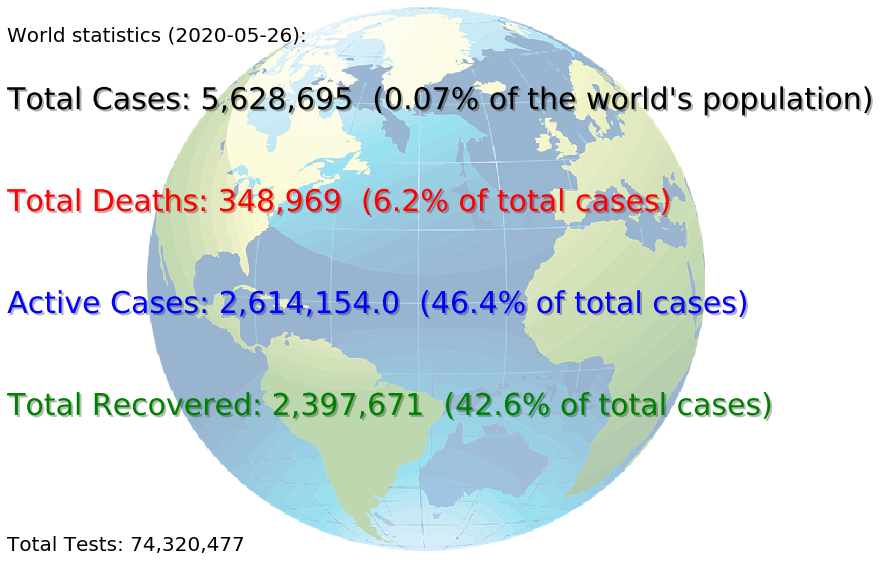

In [14]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
im = plt.imread('https://i.pinimg.com/originals/2e/16/38/2e1638b1ceacd2474452dad58ad2227b.png')
plt.imshow(im, extent=[0.2,1,0.2,1], zorder=0, aspect='auto', alpha=0.4)
plt.text(0, 0.95,f'World statistics ({datetime.date.today()}):', fontsize=20)
plt.text(0, 0.85,f'Total Cases: {df["TotalCases"].sum():,}  '\
         f'({round(df["TotalCases"].sum()/df["Population(2020)"].sum()*100,2)}% of the world\'s population)',
         color='black', fontsize=30,path_effects=[path_effects.withSimplePatchShadow()]);
plt.text(0, 0.7,f'Total Deaths: {int(df["TotalDeaths"].sum()):,}  '\
         f'({round(df["TotalDeaths"].sum()/df["TotalCases"].sum()*100,2)}% of total cases)',color='r', fontsize=30,
        path_effects=[path_effects.withSimplePatchShadow()]);
plt.text(0, 0.55,f'Active Cases: {df["ActiveCases"].sum():,}  '\
         f'({round(df["ActiveCases"].sum()/df["TotalCases"].sum()*100,1)}% of total cases)',color='b', fontsize=30,
        path_effects=[path_effects.withSimplePatchShadow()]);
plt.text(0, 0.4,f'Total Recovered: {int(df["TotalRecovered"].sum()):,}  '\
         f'({round(df["TotalRecovered"].sum()/df["TotalCases"].sum()*100,1)}% of total cases)',color='g', fontsize=30,
        path_effects=[path_effects.withSimplePatchShadow()]);
plt.text(0, 0.2,f'Total Tests: {int(df["TotalTests"].sum()):,}',color='black', fontsize=20);
plt.axis('off');

<br>
<br>
<br>
<br>
<br>




### Worldwide Covid19 choropleth map 

In [15]:
world_map = folium.Map(location=[10,0], tiles="cartodbpositron", zoom_start=2, max_zoom=6, min_zoom=2)
with open('world-countries.json') as f:
    world_geo = json.load(f)

countries_dict =({'United States' : 'United States of America', 'UAE': 'United Arab Emirates',
                 'Palestine':'West Bank'})

data = np.log2(df[['TotCases_1M']]).reset_index()
data.Country.replace(countries_dict, inplace=True)

choropleth = folium.Choropleth(
    geo_data=world_geo,
    name='choropleth',
    data=data,
    columns=['Country', 'TotCases_1M'],
    key_on='feature.properties.name',
    fill_color='OrRd',
    fill_opacity=0.9,
    line_opacity=0.2,
    nan_fill_color='#fef0d9',
    nan_fill_opacity=0.2,
    legend_name='TotCases_1M log scale',
    highlight=True,
    line_color='black'
).add_to(world_map)

style_function = "font-size: 15px; font-weight: bold"

world_map

In [16]:
df.columns

Index(['TotalCases', 'NewCases', 'TotalDeaths', 'TotalRecovered',
       'ActiveCases', 'Serious', 'TotCases_1M', 'Deaths/1Mpop', 'TotalTests',
       'Tests/1Mpop', 'Population', 'Population(2020)', 'Density(P/Km²)',
       'Fert.Rate', 'MedAg', 'UrbanPop%', 'Cases/Test', 'Deaths/Cases',
       'Recovered/Cases'],
      dtype='object')

### Looking at the statistics for TotalCases, ,<br> We can see that most of the cases comes from a small number of countries.

count        211.0
mean       26676.0
std       128355.0
min            1.0
25%          141.0
50%         1053.0
75%         8438.0
max      1710558.0
Name: TotalCases, dtype: float64


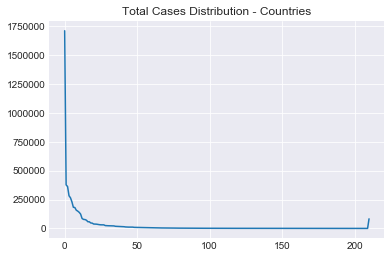

In [17]:
plt.style.use('seaborn-darkgrid')
print(df['TotalCases'].describe().round())
df.reset_index()['TotalCases'].plot(title='Total Cases Distribution - Countries');

### Let's look at the current global view with a 100% stacked bar charts showing each stack component's relative contribution (in percents) to the whole bar and the whole entity.
* Filtered out countries with fewer than 5000 total cases.
* United Kingdom and Netherlands Total Recovered data is missing.  

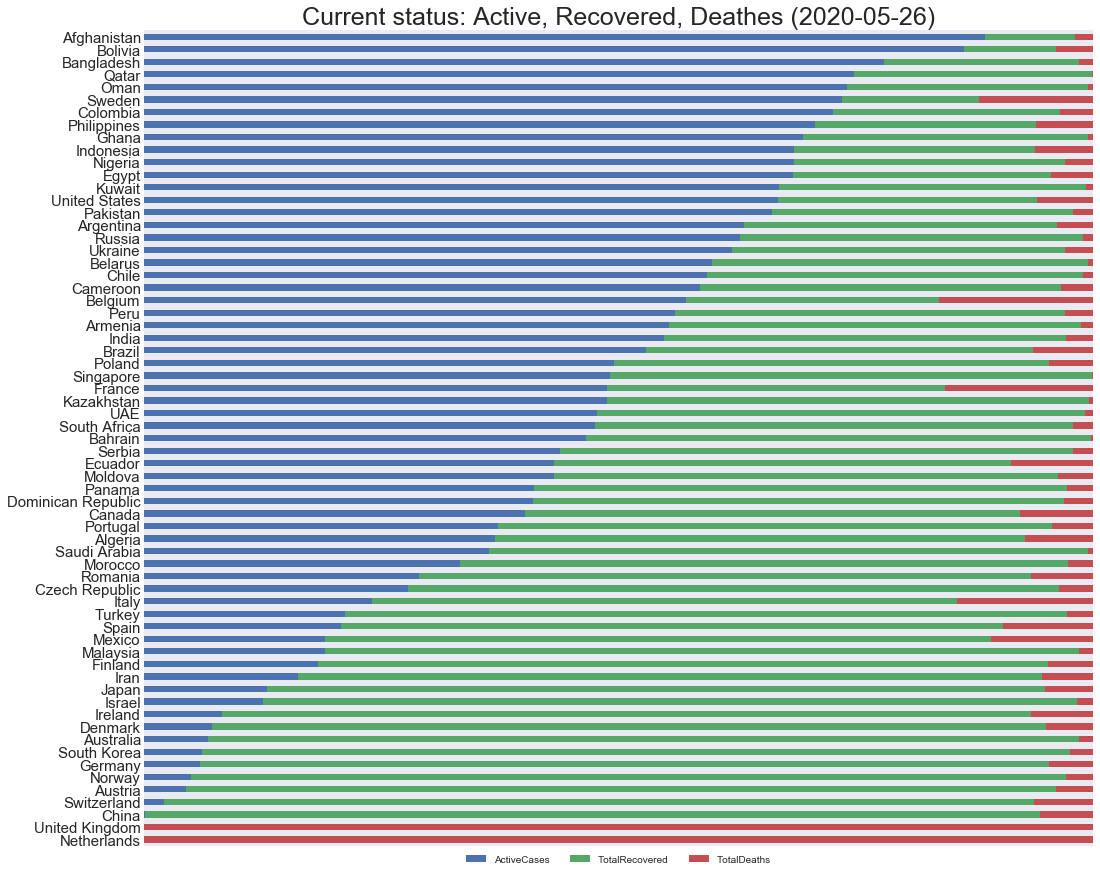

In [18]:
plot_stacked_pct()

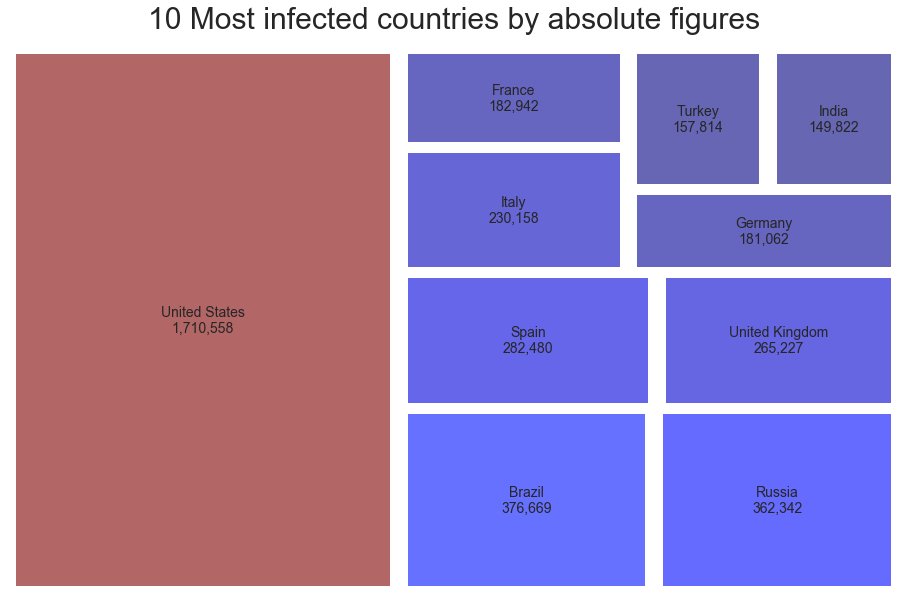

In [19]:
plot_20cq(by='worst_cases', boxes=10)

### Now, let's look at the number of fatalities divided by the number of confirmed cases (death rate)

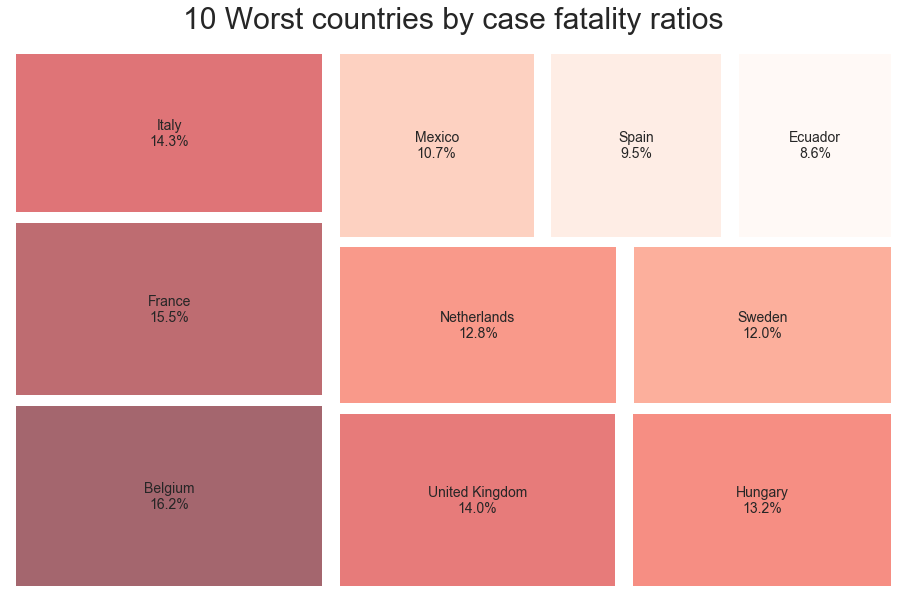

In [20]:
plot_20cq(by='mortality_rate', boxes=10)

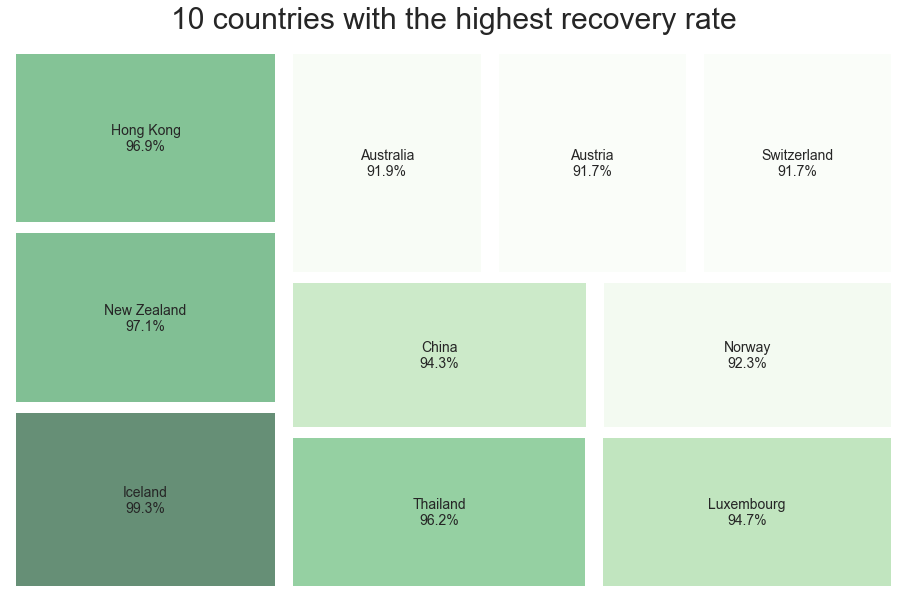

In [21]:
plot_20cq(by='recovery_rate', boxes=10)

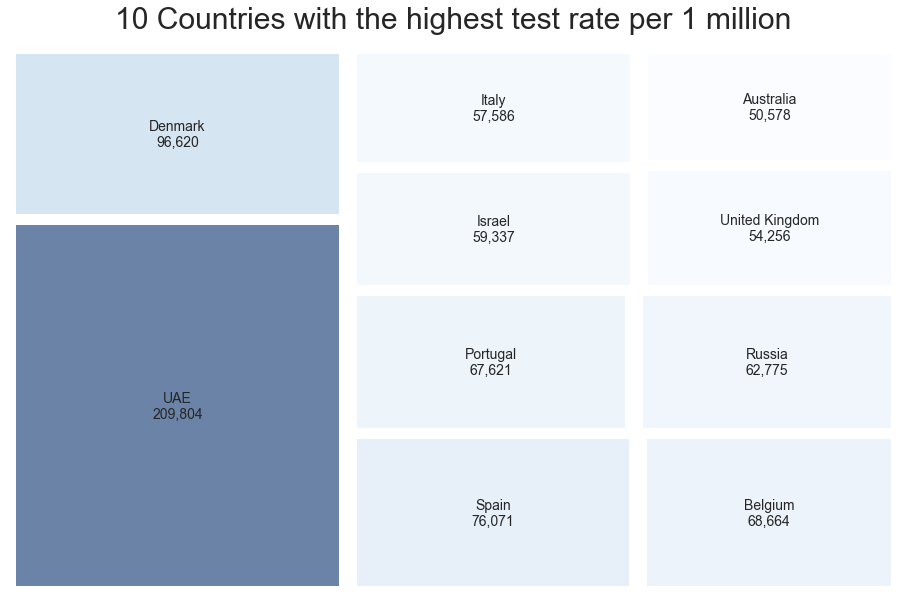

In [22]:
plot_20cq(by='test_rate', boxes=10)

#### Main statistics for the numeric columns

In [23]:
# Main statistics for numeric columns
df.describe().T.round(1)

count        mean          std     min       25%        50%  \
TotalCases        211.0     26676.3     128354.8     1.0     141.0     1053.0   
NewCases          211.0       224.9        892.2     0.0       0.0        0.0   
TotalDeaths       211.0      1653.9       8290.6     0.0       3.0       21.0   
TotalRecovered    211.0     11363.4      42174.9     0.0      59.5      503.0   
ActiveCases       211.0     12389.4      81872.6    -3.0      21.5      313.0   
Serious           211.0       251.9       1466.2     0.0       0.0        2.0   
TotCases_1M       211.0      1193.7       2292.0     0.9      83.5      263.0   
Deaths/1Mpop      211.0        52.6        142.5     0.0       0.6        5.0   
TotalTests        211.0    352229.7    1337270.4     0.0    1935.0    25216.0   
Tests/1Mpop       211.0     22852.2      37824.1     0.0    1150.0     6360.0   
Population        211.0  36310381.3  142092299.6  3469.0  881151.5  6861713.0   
Population(2020)  211.0  36741955.7  142198752.2  3480.0  882456.5  6948445.0   
Density(P/Km²)    211.0       502.5       2455.9     0.0      37.0       94.0   
Fert.Rate         211.0         2.4          1.5     0.0       1.6        2.1   
MedAg             211.0        27.6         12.8     0.0      19.5       29.0   
UrbanPop%         211.0        57.6         25.9     0.0      39.0       59.0   
Cases/Test        211.0         inf          NaN     0.0       0.0        0.0   
Deaths/Cases      211.0         0.0          0.0     0.0       0.0        0.0   
Recovered/Cases   211.0         0.6          0.3     0.0       0.4        0.6   

                         75%           max  
TotalCases            8438.5  1.710558e+06  
NewCases                30.0  8.915000e+03  
TotalDeaths            214.0  9.993000e+04  
TotalRecovered        4363.5  4.669800e+05  
ActiveCases           2509.0  1.143648e+06  
Serious                 22.0  1.711400e+04  
TotCases_1M           1477.5  1.963200e+04  
Deaths/1Mpop            29.5  1.238000e+03  
TotalTests          224710.5  1.523527e+07  
Tests/1Mpop          25571.0  2.098040e+05  
Population        24787734.0  1.439324e+09  
Population(2020)  25939079.0  1.439324e+09  
Density(P/Km²)         237.5  2.633700e+04  
Fert.Rate                3.0  7.000000e+00  
MedAg                   38.0  4.800000e+01  
UrbanPop%               79.0  1.000000e+02  
Cases/Test               0.1           inf  
Deaths/Cases             0.1  2.000000e-01  
Recovered/Cases          0.8  1.000000e+00

#### We can see that most of the data comes from a small number of countries.

In [24]:
df['World%TotalCases'] = np.round(df['TotalCases'] / df['TotalCases'].sum() ,3)
print(f'Worldwide Coronavirus Cases: {df.TotalCases.sum():,}')
df.sort_values(by='TotalCases', ascending=False)[[ 'TotalCases','World%TotalCases']].head(5)\
.style.format({'TotalCases':'{:,.0f}','World%TotalCases':'{:,.1%}'}).background_gradient(cmap='Reds')\
.set_caption('Worst hit countries')\
.background_gradient(cmap='binary',subset=["TotalCases"])\
.background_gradient(cmap='Oranges',subset=["World%TotalCases"])

Worldwide Coronavirus Cases: 5,628,695


### Five countries have almost 55% of all cases worldwide.

<!-- We will drop countries with less than 100 positive cases as they are less relevant to our overall statistics. -->

## Global spread of COVID-19 
#### (Countries with a population of over 1,000,000)

In [25]:
worst_c = df[df['Population(2020)']>1_000_000].sort_values('Deaths/1Mpop',ascending=False)
worst_c = worst_c[['TotCases_1M', 'Deaths/1Mpop']].head(round(0.1 * len(worst_c)))
worst_c.style.format("{:,.0f}").background_gradient(cmap='Reds').set_caption('Worst hit countries')

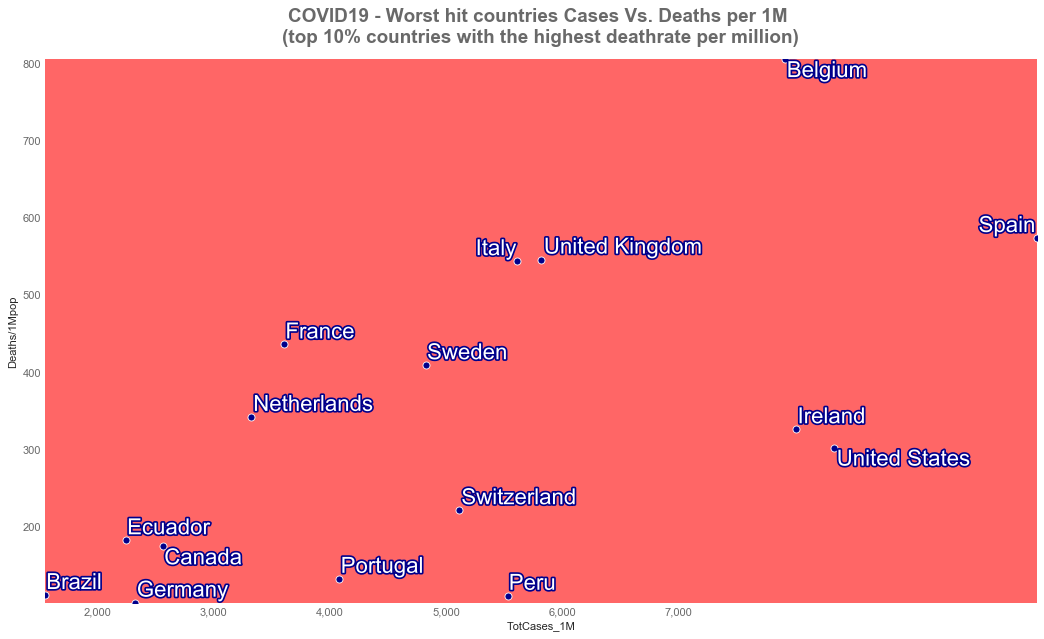

In [26]:
worst_countries()

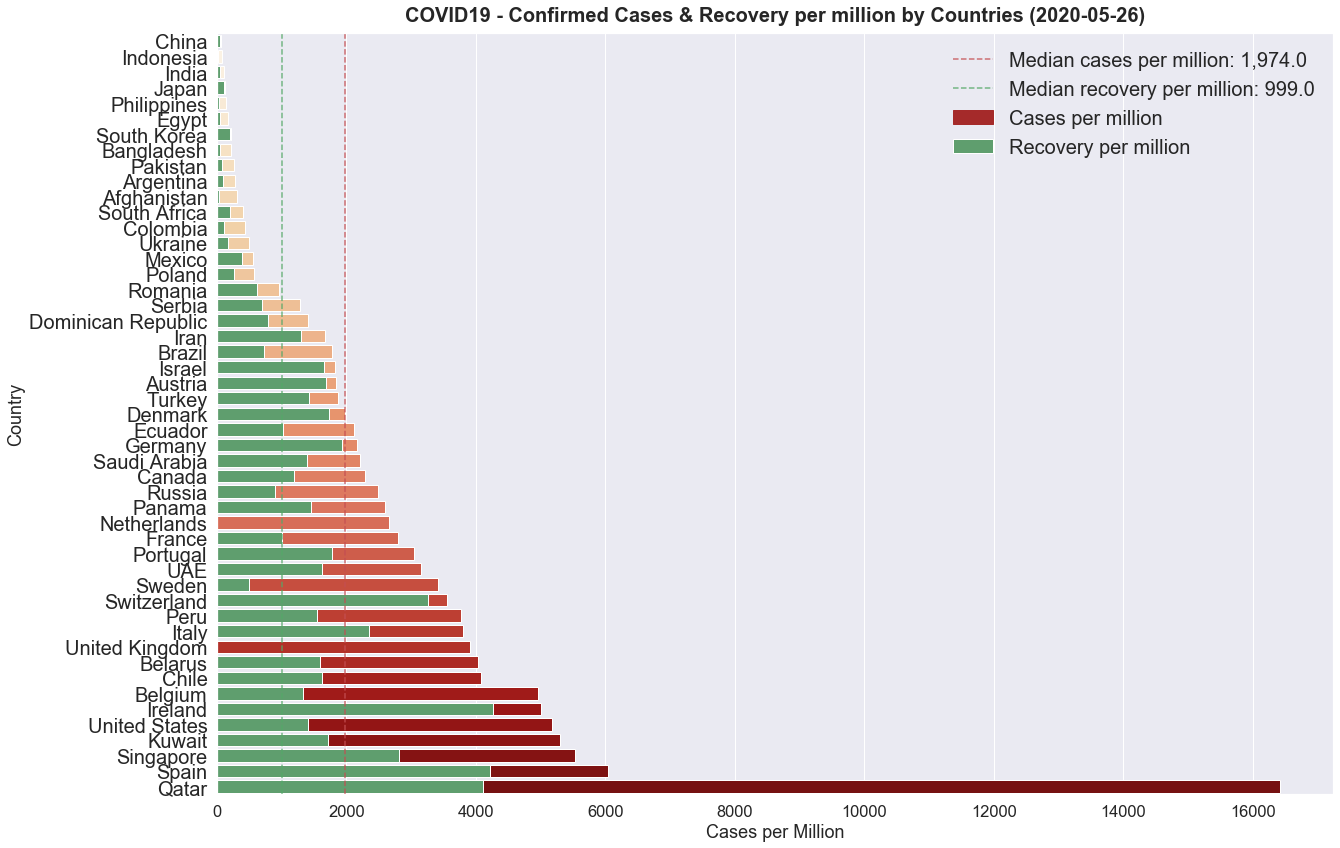

In [27]:
countries_cases_recovery()

In [28]:
df_ir = df[(df['Tests/1Mpop'] > 5000) & (df['TotalCases']>5000)].reset_index()
df_ir['recoverd\cases'] = df_ir['TotalRecovered'] / (df_ir['TotalCases'] - df_ir['TotalDeaths'])
df_ir['Cases_tests_recoverd_retio'] = df_ir['recoverd\cases'] * df_ir['Cases/Test']
df_ir = df_ir.sort_values(by='Cases/Test')

In [29]:
df = df[df['TotalCases'] >1000]

## <u>Correlations:</u>

### In order to try to find correlations that could be more statistically valid,<br>I have filtered out countries with fewer than 1000 total cases.

Number of countries: 109


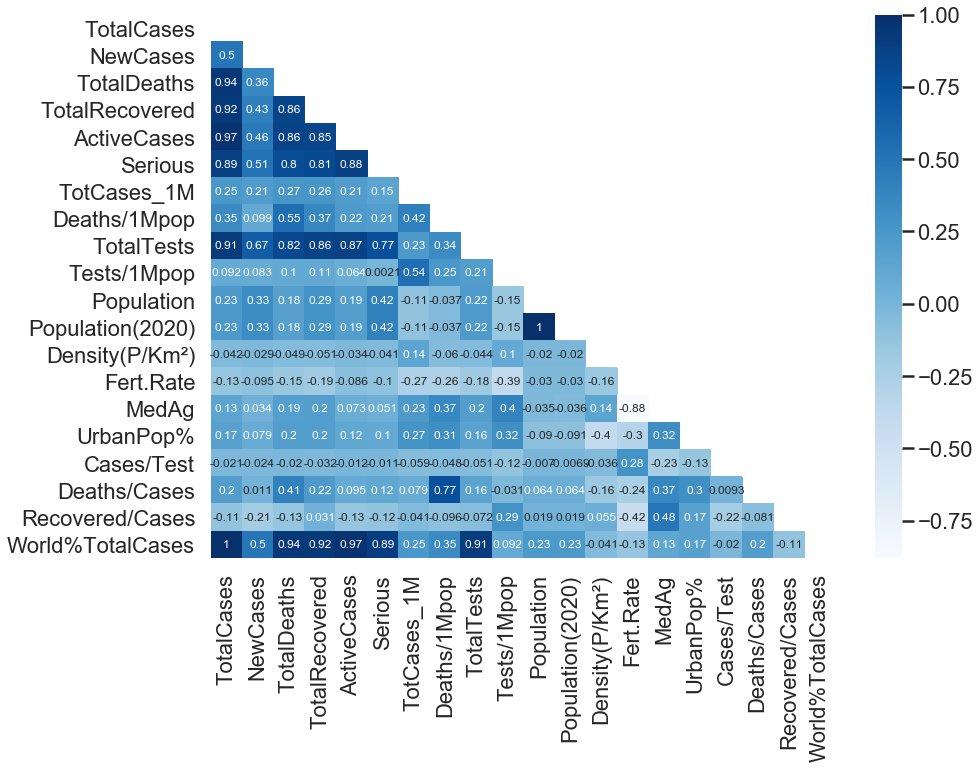

In [30]:
print(f"Number of countries: {len(df)}")
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(corr, mask=mask, cmap='Blues', annot=True,annot_kws={"size":12})
    sns.set(font_scale=1.5);


The majority of the high correlations listed above derive from the dependent variables and their ratios,<br>
Let's look at the less clear relationships:

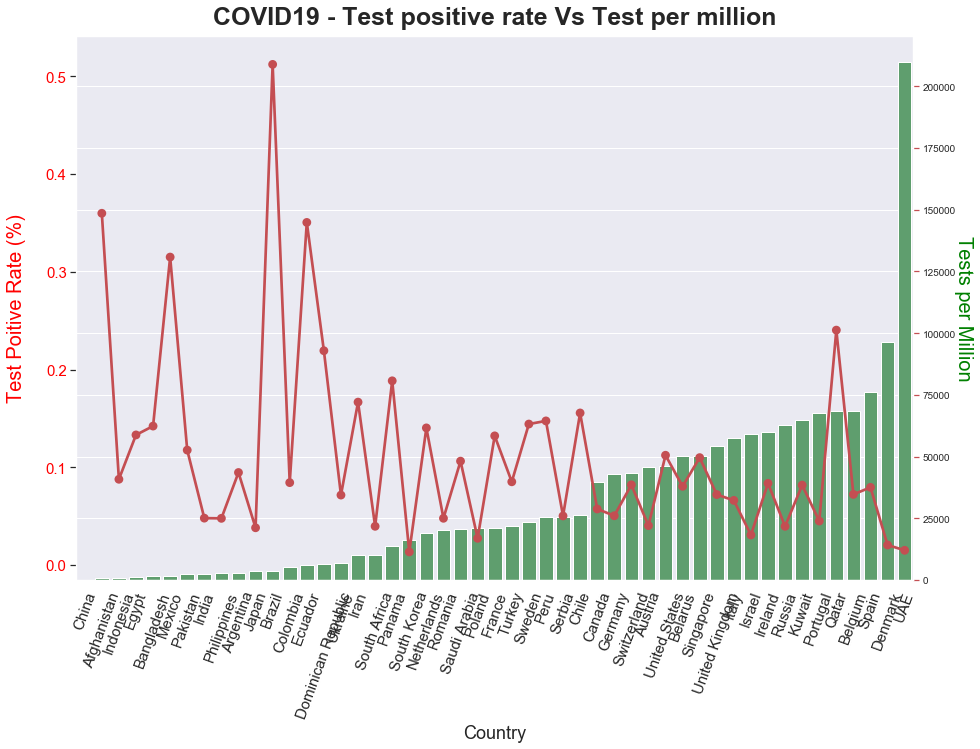

In [31]:
countries_tpr_tr()

In [32]:
print(f"The correlation between TPR (Test Positive Rate) and number of test's per million is "\
      f"{round(df[df['Tests/1Mpop']>0]['Tests/1Mpop'].corr(df[df['Tests/1Mpop']>0]['Cases/Test']),2)},\nwhich means "\
      f"the TPR goes down as more people are tested.")


The correlation between TPR (Test Positive Rate) and number of test's per million is -0.12,
which means the TPR goes down as more people are tested.


<b>Urban percentages</b> are the number of persons residing in an area identified as 'urban' per 100 total population,<br>
let's see if thier is any correlation between that percentage and the ratio of deaths / cases.

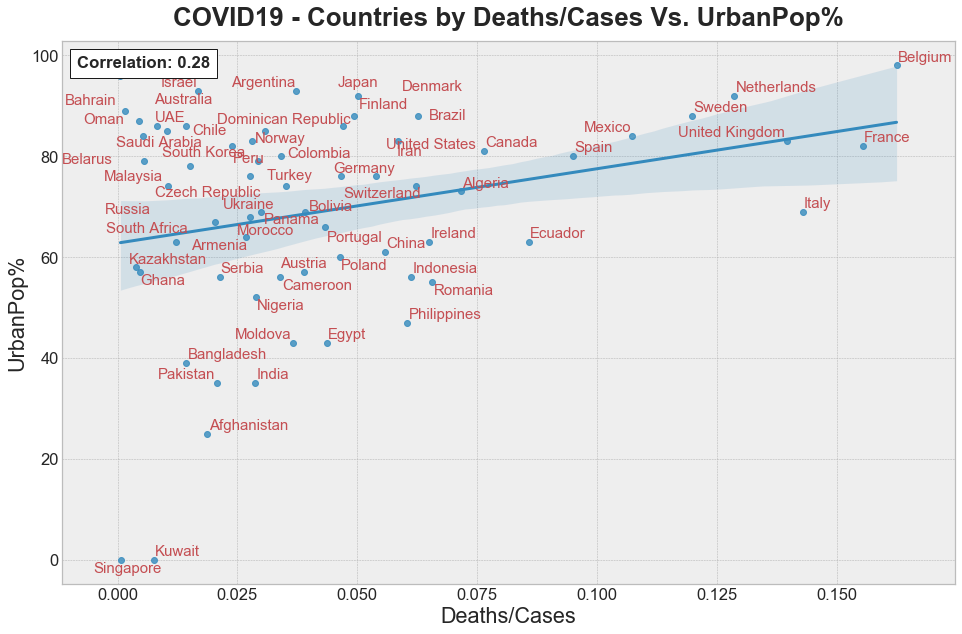

In [33]:
pair_corr_plot(df,tc_threshold=5000, x='Deaths/Cases',y='UrbanPop%')

### Explore the median age and death rate correlation, filter out countries with fewer than 1,000 deaths.

In [34]:
# Median age correlation, with countries that has more than 1,000 deaths.
df_cor_age = df[df['TotalDeaths']>1000][['Deaths/Cases', 'MedAg']].sort_values('MedAg', ascending=False)
df_cor_age = df_cor_age[df_cor_age['MedAg'] > 10]
print(df_cor_age.corr())
df_cor_age.reset_index()

              Deaths/Cases    MedAg
Deaths/Cases       1.00000  0.39869
MedAg              0.39869  1.00000


Country  Deaths/Cases  MedAg
0            Italy      0.142845     47
1          Germany      0.046658     46
2         Portugal      0.043281     46
3            Spain      0.095005     45
4      Netherlands      0.128483     43
5          Romania      0.065657     43
6      Switzerland      0.062254     43
7           France      0.155415     42
8           Poland      0.046326     42
9          Belgium      0.162458     42
10          Canada      0.076352     41
11          Sweden      0.119774     41
12          Russia      0.010507     40
13  United Kingdom      0.139684     40
14   United States      0.058420     38
15         Ireland      0.065026     38
16           China      0.055837     38
17          Brazil      0.062670     33
18            Iran      0.053817     32
19          Turkey      0.027684     32
20            Peru      0.029271     31
21       Indonesia      0.061213     30
22          Mexico      0.107348     29
23         Ecuador      0.085745     28
24           India      0.028747     28
25        Pakistan      0.020743     23

### Cheak death rate at top and bottom quantiles (deaths/total cases)
So let's take countries with a median age > 0.75 quantile of median age, <br>
and countries with a median age < 0.25 quantile of median age to investigate the mortality rates in those two categories.

In [35]:
# Cheak death rate at top and bottom quantiles (deaths/total cases)
df_med = df[df['MedAg'] !=0].copy()
df_topQ_Age = df_med[df_med['MedAg'] > df_med['MedAg'].quantile(0.75)]
df_bottomQ_Age = df_med[df_med['MedAg'] < df_med['MedAg'].quantile(0.25)]

death_rate_top10q_med_age = df_topQ_Age['TotalDeaths'].sum()/df_topQ_Age['TotalCases'].sum() 
death_rate_bottom10q_med_age = df_bottomQ_Age['TotalDeaths'].sum()/df_bottomQ_Age['TotalCases'].sum() 

print(f"Death rate Top 25% median age countries: {round(death_rate_top10q_med_age *100,1)}%")
print(f"Death rate Bottom 25% median age countries: {round(death_rate_bottom10q_med_age *100,1)}%")

Death rate Top 25% median age countries: 9.1%
Death rate Bottom 25% median age countries: 2.8%


### Let's look at the correlation for all countries with more than 5,000 total cases.

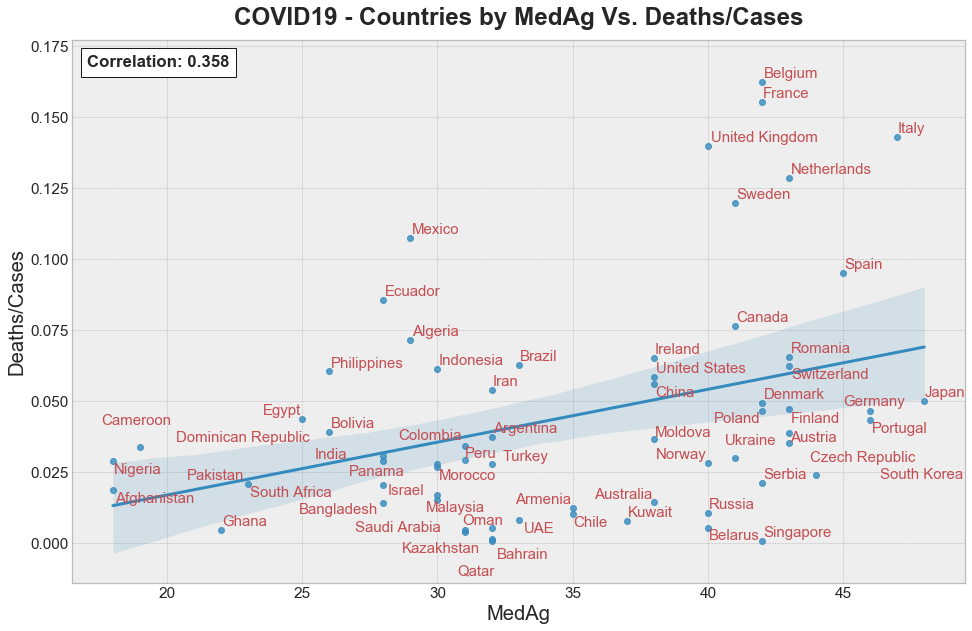

In [36]:
pair_corr_plot(df, tc_threshold=5000)

### And now the correlation for all countries with more than 20,000 total cases.

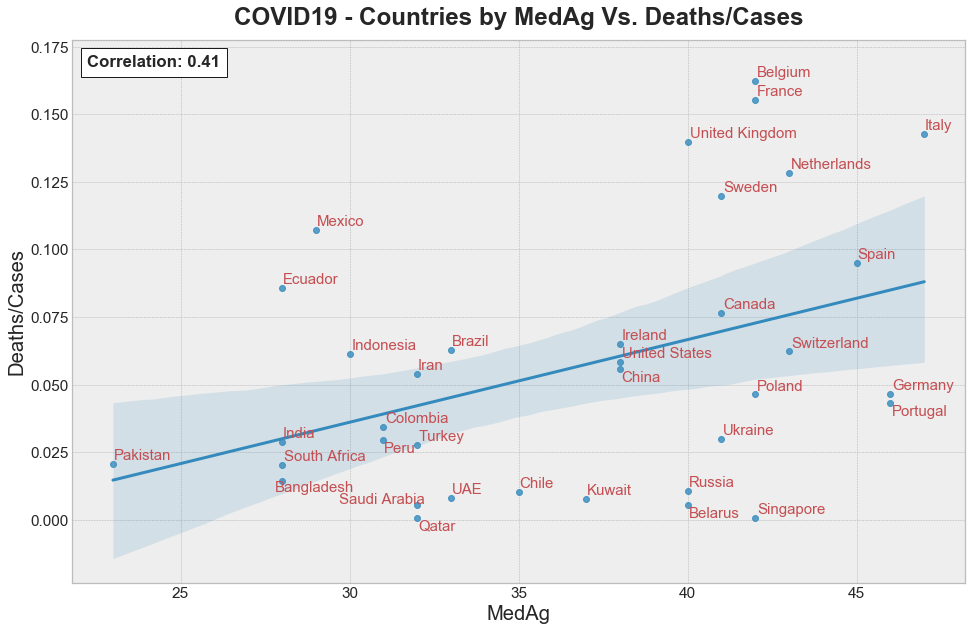

In [37]:
pair_corr_plot(df, tc_threshold=20000)

In [38]:
df.head()

TotalCases  NewCases  TotalDeaths  TotalRecovered  \
Country                                                             
United States      1710558    4332.0      99930.0        466980.0   
Brazil              376669       0.0      23606.0        153833.0   
Russia              362342    8915.0       3807.0        131129.0   
Spain               282480       0.0      26837.0        196958.0   
United Kingdom      265227    4043.0      37048.0             0.0   

                ActiveCases  Serious  TotCases_1M  Deaths/1Mpop  TotalTests  \
Country                                                                       
United States     1143648.0  17114.0       5171.0         302.0  15235274.0   
Brazil             199230.0   8318.0       1773.0         111.0    735224.0   
Russia             227406.0   2300.0       2483.0          26.0   9160590.0   
Spain               58685.0    854.0       6042.0         574.0   3556567.0   
United Kingdom          0.0   1559.0       3909.0         546.0   3681295.0   

                Tests/1Mpop   Population  Population(2020)  Density(P/Km²)  \
Country                                                                      
United States       46054.0  330811717.0         331002651              36   
Brazil               3461.0  212409786.0         212559417              25   
Russia              62775.0  145928485.0         145934462               9   
Spain               76071.0   46753049.0          46754778              94   
United Kingdom      54256.0   67851047.0          67886011             281   

                Fert.Rate  MedAg  UrbanPop%  Cases/Test  Deaths/Cases  \
Country                                                                 
United States         1.8     38       83.0    0.112276      0.058420   
Brazil                1.7     33       88.0    0.512319      0.062670   
Russia                1.8     40       74.0    0.039554      0.010507   
Spain                 1.3     45       80.0    0.079425      0.095005   
United Kingdom        1.8     40       83.0    0.072047      0.139684   

                Recovered/Cases  World%TotalCases  
Country                                            
United States          0.272999             0.304  
Brazil                 0.408404             0.067  
Russia                 0.361893             0.064  
Spain                  0.697246             0.050  
United Kingdom         0.000000             0.047

We can also see the correlation between fertility rate and median age.<br> 
This process mostly in developed countries results in a rise in the median age of the population,<br>
when fertility rates decrease while life expectancy remains constant or improves at the older ages.

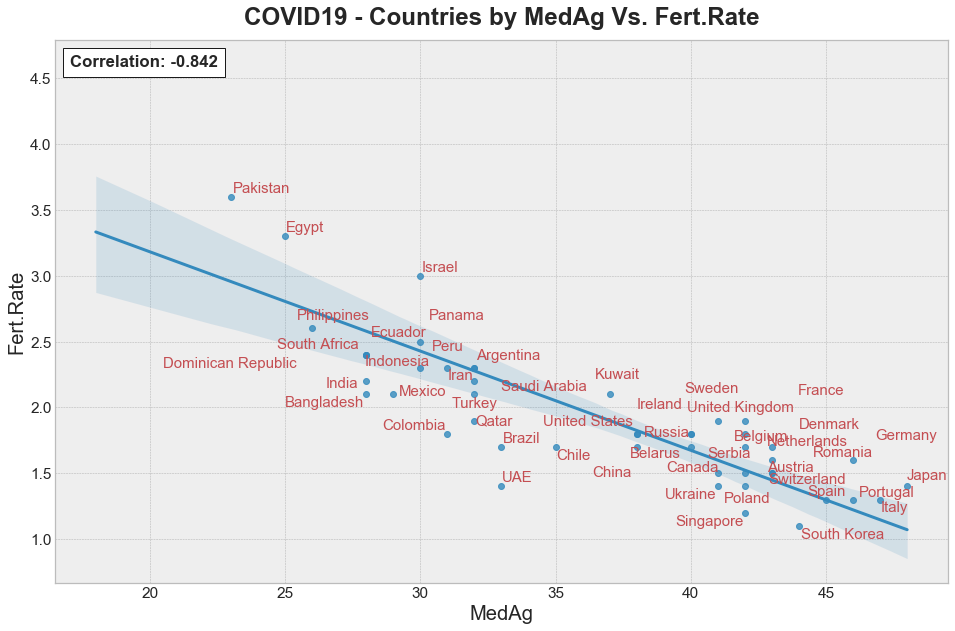

In [39]:
pair_corr_plot(df,y='Fert.Rate', x='MedAg')

To further inspect the relationship between age and death from coronarvirus, we need more than median age data,<br>
so I've scrapped a list of countries and their dependency ratios (from Wikipedia All data is for the year 2020. Source is the CIA World Factbook.),<br> merged them with our data set,to inspect the link between the elderly dependence and the Death / Case ratios.<br>
<b>The elderly dependency ratio</b> is the ratio of the elderly population (ages 65+) per 100 people of working age (ages 15-64)<br><br>


![Dependency ratio](https://wikimedia.org/api/rest_v1/media/math/render/svg/7ffdce78a4e6395a8a36f5bc5df82a5726edb354)


In [40]:
dep = pd.read_html('https://en.wikipedia.org/wiki/List_of_countries_by_dependency_ratio')[0]
df_dep = df.merge(dep,left_index=True, right_on='Country')

df_dep[['TotCases_1M', 'Deaths/Cases','elderly dependency ratio']].corr()

TotCases_1M  Deaths/Cases  elderly dependency ratio
TotCases_1M                  1.000000      0.101395                  0.096517
Deaths/Cases                 0.101395      1.000000                  0.488840
elderly dependency ratio     0.096517      0.488840                  1.000000

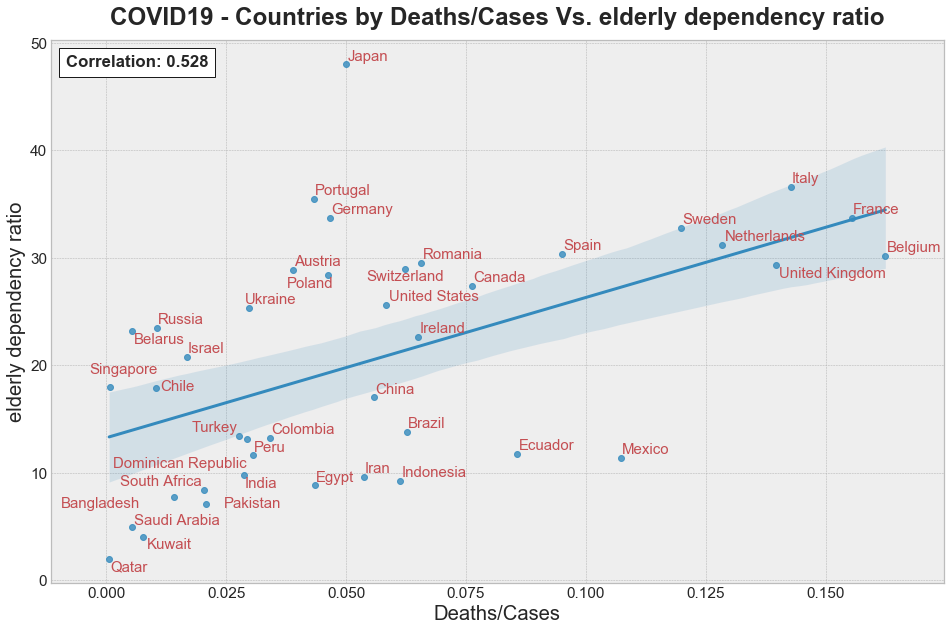

In [41]:
pair_corr_plot(df_dep,tc_threshold=15000, x='Deaths/Cases',y='elderly dependency ratio')

<b>As we have done before,</b> let's cheek again the death rate at top and bottom quantiles (deaths/total cases)<br>
So we'll take countries with <b>elderly dependency ratio > 0.75</b> quantile,<br>
and countries with <b>elderly dependency ratio < 0.25 </b> quantile, to inspect mortality rates in these two classes:

In [42]:
# Cheak death rate at top and bottom quantiles (deaths/total cases)
df_topQ_edr = df_dep[df_dep['elderly dependency ratio'] > df_dep['elderly dependency ratio'].quantile(0.75)]
df_bottomQ_edr = df_dep[df_dep['elderly dependency ratio'] < df_dep['elderly dependency ratio'].quantile(0.25)]

death_rate_top10q_edr = df_topQ_edr['TotalDeaths'].sum()/df_topQ_edr['TotalCases'].sum() 
death_rate_bottom10q_edr = df_bottomQ_edr['TotalDeaths'].sum()/df_bottomQ_edr['TotalCases'].sum() 

print(df_dep['elderly dependency ratio'].describe())
print(f"Death rate for countries in the Highest 25% elderly dependency ratio: {round(death_rate_top10q_edr *100,1)}%")
print(f"Death rate for countries in the Lowest 25% elderly dependency ratio: {round(death_rate_bottom10q_edr *100,1)}%")

count    107.000000
mean      17.619626
std       10.863714
min        2.000000
25%        7.700000
50%       13.800000
75%       27.150000
max       48.000000
Name: elderly dependency ratio, dtype: float64
Death rate for countries in the Highest 25% elderly dependency ratio: 10.9%
Death rate for countries in the Lowest 25% elderly dependency ratio: 1.1%


<span style="background-color:Yellow"><b>Now we can see the connection between age distribution and the ratio of deaths/cases more clearly.<br>
Covid-19 mortality rates are higher in those countries where we already have an ageing population,<br> of course their are other variables that can affect the number of cases and fertility rates such as, lock-downs, social distance,<br> climte, advanced health care system .. etc ..that require further exploring and behind the scope of our data for this eda.</b></span>

<br>
<br>
<br>
<br>
<br>


### Let's analyze and compare the OECD countries.

![covid image](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQPZ2DW5AS0fWlYeksl2N5zivVbjQouqeQqx5Z-uEE8YwwL-ipV&usqp=CAU)


In [43]:
pd.set_option('display.max_rows', 500)
df_oecd = df[df.index.isin(oecd_countries)]
df_oecd['% Deaths'] = (df_oecd['TotalDeaths'] / df_oecd['TotalCases']).round(3)
df_oecd['% Recovered'] = (df_oecd['TotalRecovered'] / df_oecd['TotalCases']).round(3)
df_oecd['% Active'] = (df_oecd['ActiveCases'] / df_oecd['TotalCases']).round(3)
df_oecd[['TotalCases','TotalDeaths','ActiveCases','TotalRecovered','% Deaths', '% Active','% Recovered']].style\
.format({'TotalCases':'{:,.0f}', 'TotalDeaths':'{:,.0f}','ActiveCases':'{:,.0f}','TotalRecovered':'{:,.0f}',
         '% Deaths':'{:.01%}','% Active':'{:.01%}','% Recovered':'{:.01%}'})\
.background_gradient(cmap='Blues',subset=["TotalCases"])\
.background_gradient(cmap='Reds',subset=["TotalDeaths"])\
.background_gradient(cmap='OrRd',subset=["% Deaths"])\
.background_gradient(cmap='Greens',subset=["TotalRecovered"])\
.background_gradient(cmap='Greens',subset=["% Recovered"])\
.background_gradient(cmap='OrRd',subset=["ActiveCases"])\
.background_gradient(cmap='PuBu',subset=["% Active"])\
.set_caption('OECD countries')

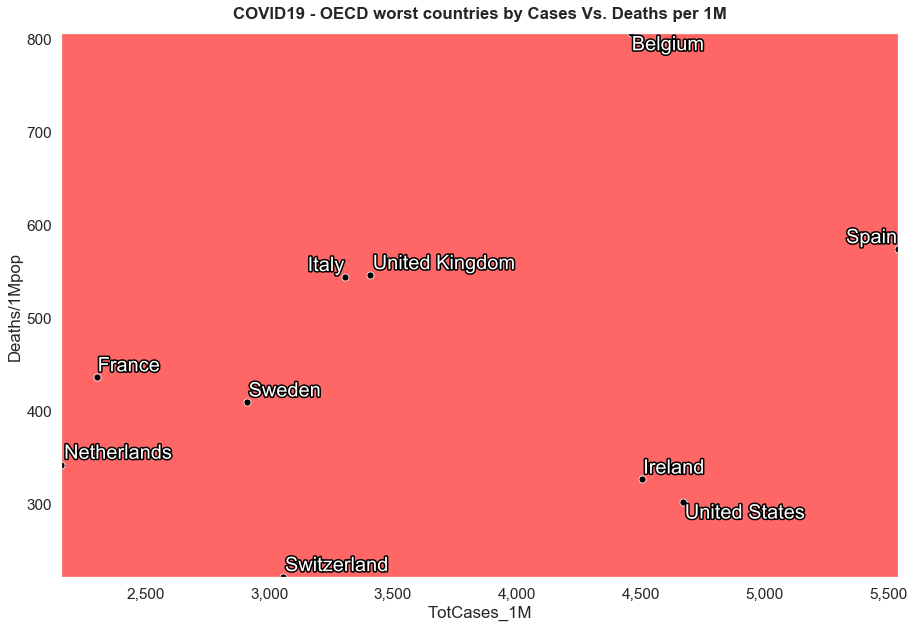

In [44]:
import matplotlib.patheffects as path_effects

plt.style.use('seaborn-deep')

df_oecd_chart = df[df.index.isin(oecd_countries)].reset_index()
median_ir = df_oecd_chart['Deaths/1Mpop'].median()
df_oecd_chart = df_oecd_chart.sort_values('Deaths/1Mpop', ascending=False).head(10)
fig, ax = plt.subplots(figsize = (15, 10))
sns.scatterplot(x='TotCases_1M', y='Deaths/1Mpop', data=df_oecd_chart, s=50, color='black');
text = [plt.text(x, y, z, color='w', size=20,path_effects=[path_effects.Stroke(linewidth=3,
        foreground='black'), path_effects.Normal()]) for x, y, z in zip(df_oecd_chart['TotCases_1M'],
        df_oecd_chart['Deaths/1Mpop'],df_oecd_chart['Country'])]
plt.title(f'COVID19 - OECD worst countries by Cases Vs. Deaths per 1M',pad=15,weight = 'semibold')
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
plt.margins(x=0,y=0);plt.grid(b=None);
ax.patch.set_facecolor('red');ax.patch.set_alpha(0.6);
adjust_text(text);
path_effects=[path_effects.withSimplePatchShadow()]

In [45]:
df_oecd.reset_index(inplace=True)

fig = go.Figure(data=[
    go.Pie(labels=df_oecd['Country'], 
           values=df_oecd['TotalCases'], 
           hole=.45,
           textinfo='label+percent'
          )
])

fig.update_layout(
    height=700,
    width=700,
    title_text="Positive Cases Percentage - OECD Countries",
    annotations=[
        dict(text='Positive<br>Cases', showarrow=False),
    ]
)
fig.update_traces(textposition='inside')
fig.show()

In [46]:
print(f"** OECD countries accounts for "\
      f"{round(df_oecd['TotalCases'].sum()/df['TotalCases'].sum()*100,1)}% of cases worldwide.")

** OECD countries accounts for 64.9% of cases worldwide.


In [47]:
df_oecd.set_index(df_oecd['Country'], inplace=True)

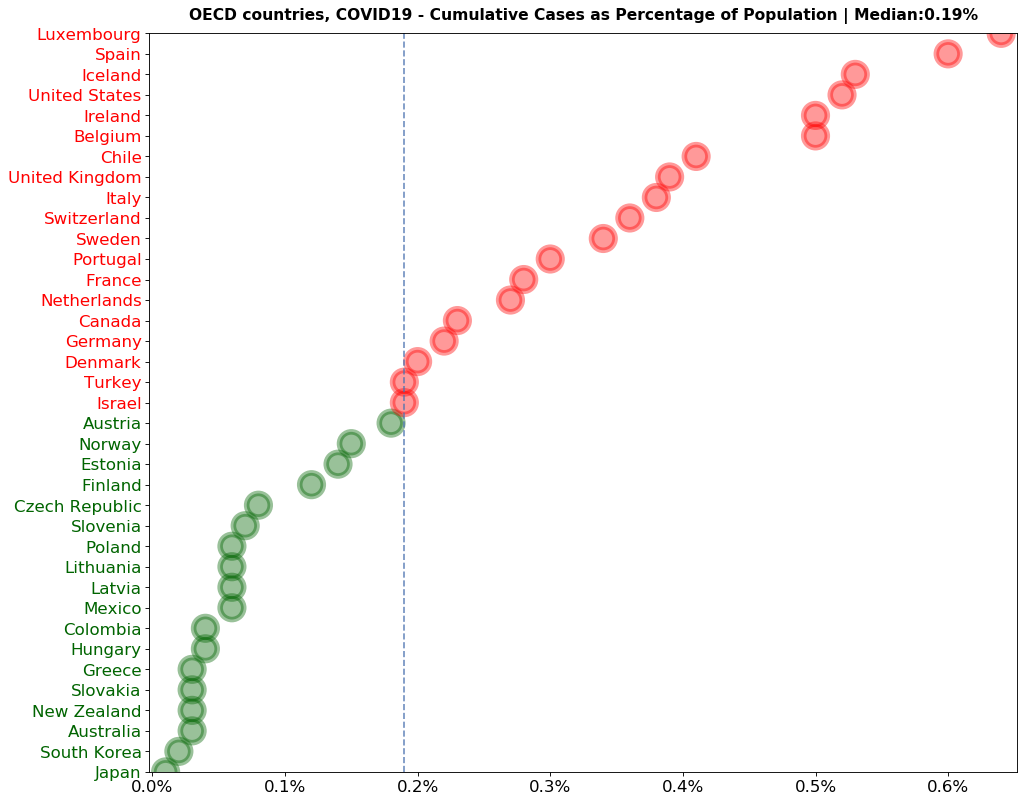

In [48]:
plt.style.use('default')
plt.style.use('seaborn-deep')
plt.figure(figsize=(14,12), dpi= 80)
df_pct_p = round((df_oecd['TotalCases'] / df_oecd['Population(2020)']*100),2).sort_values()
df_pct_color = ['darkgreen' if x < df_pct_p.median() else 'red' for x in df_pct_p]
plt.scatter(x=df_pct_p, y=df_pct_p.index,s=450, alpha=0.4, linewidth=5, color=df_pct_color)
plt.ylabel(''); plt.yticks(fontsize=15); plt.xticks(fontsize=15);
plt.margins(0)
plt.title(f'OECD countries, COVID19 - Cumulative Cases as Percentage of Population | Median:{df_pct_p.median()}%',
          fontsize=14,pad=12,weight ='semibold');
[ticklabel.set_color(tickcolor) for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), df_pct_color)]
plt.axvline(df_pct_p.median(), linestyle='--', c='b', alpha=0.8);
plt.gca().set_xticklabels(['{:.1f}%'.format(x) for x in plt.gca().get_xticks()]);

<br>
<br>
<br>
<br>
<br>

## United States

![US states](https://cdnuploads.aa.com.tr/uploads/Contents/2020/03/31/thumbs_b_c_f0c9e70408e03dcbd2c231d82228c08b.jpg?v=210121)


In [49]:
# US positive
us_p = usa_covid19.groupby('state')['positive'].first().sum()

# US test positive rate
us_pr =us_p /(usa_covid19.groupby('state')['totalTestResults'].first().sum())

# US recovered
us_r=usa_covid19.groupby('state')['recovered'].first().sum()

# US recovered percentage
us_rp = us_r / (usa_covid19.groupby('state')['positive'].first().sum())

# US deaths
us_d = usa_covid19.groupby('state')['death'].first().sum()

# US deaths percentage
us_dp = us_d / us_p

# US total tests
us_t = usa_covid19.groupby('state')['totalTestResults'].first().sum()



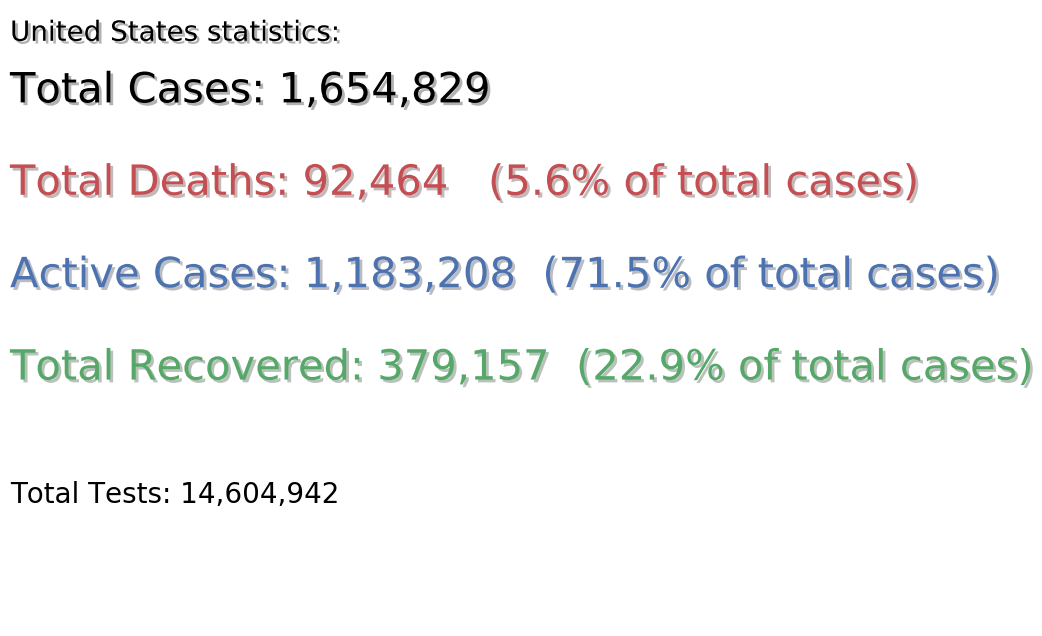

In [50]:
import matplotlib.patheffects as path_effects

fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,1,1)
plt.text(0, 0.95,'United States statistics:', fontsize=20,path_effects=[path_effects.withSimplePatchShadow()])
plt.text(0, 0.85,f"Total Cases: {int(us_p):,}", color='black', fontsize=30,path_effects=[path_effects.withSimplePatchShadow()]);
plt.text(0, 0.7,f"Total Deaths: {int(us_d):,}   ({round(us_dp*100,1)}% of total cases)",color='r', fontsize=30,
        path_effects=[path_effects.withSimplePatchShadow()]);
plt.text(0, 0.55,f'Active Cases: {int(us_p-(us_r + us_d)):,}  ({round((us_p-(us_r + us_d))/us_p*100,1)}% of total cases)',
         color='b', fontsize=30,path_effects=[path_effects.withSimplePatchShadow()]);
plt.text(0, 0.4,f'Total Recovered: {int(us_r):,}  ({round(us_r/us_p*100,1)}% of total cases)',color='g', fontsize=30,
        path_effects=[path_effects.withSimplePatchShadow()]);
plt.text(0, 0.2,f'Total Tests: {int(us_t):,}',color='black', fontsize=20);
plt.axis('off');


In [51]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}


In [52]:
# Converting US state names
usa_covid19['state'] = usa_covid19['state'].map(states)

### US Covid19 choropleth map 

In [53]:
# choropleth maps bind Pandas Data Frames and json geometries.
us_states_c = usa_covid19.groupby('state')[['positive']].first()
us_states_c= us_states_c.drop('American Samoa')
us_states_c['Confirmed_Log'] = np.log2(us_states_c['positive'])

states_geo = 'us-states1.json'
us_map = folium.Map(location=[39, -95], zoom_start=4)
folium.Choropleth(geo_data=states_geo, data=us_states_c,
             columns=[us_states_c.index, 'Confirmed_Log'],
             key_on='feature.properties.name',
             fill_color='OrRd',nan_fill_color='white', fill_opacity=0.6, line_opacity=0.3,
             highlight=True,bins=6, legend_name='US tates - Covid19 - log scale(Cases)').add_to(us_map)
 
us_map

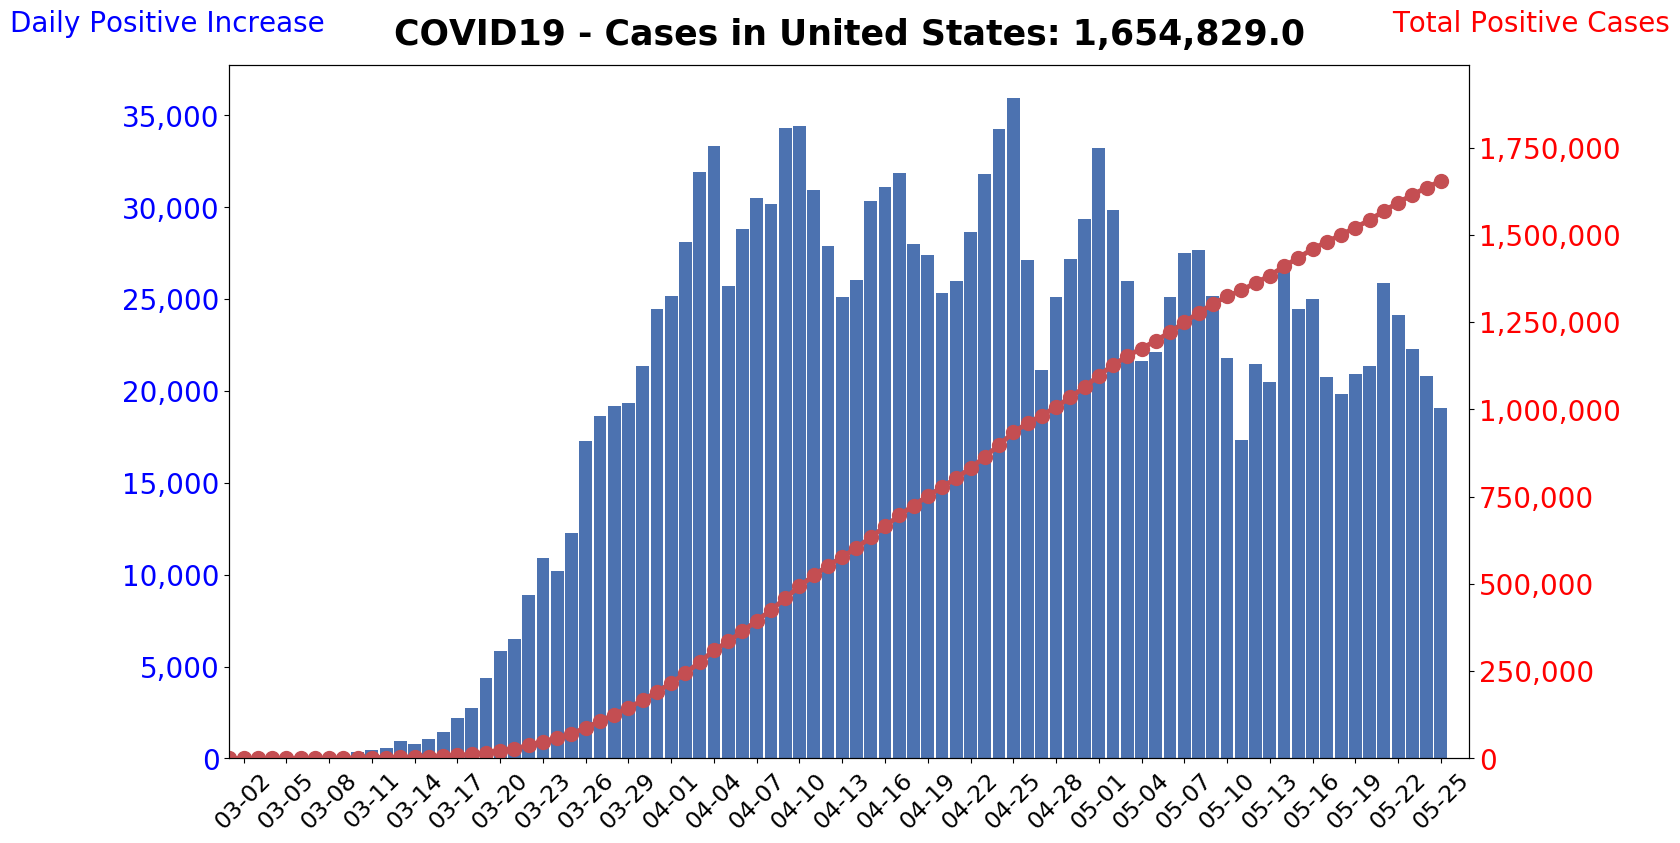

In [54]:
us_cases_ts()

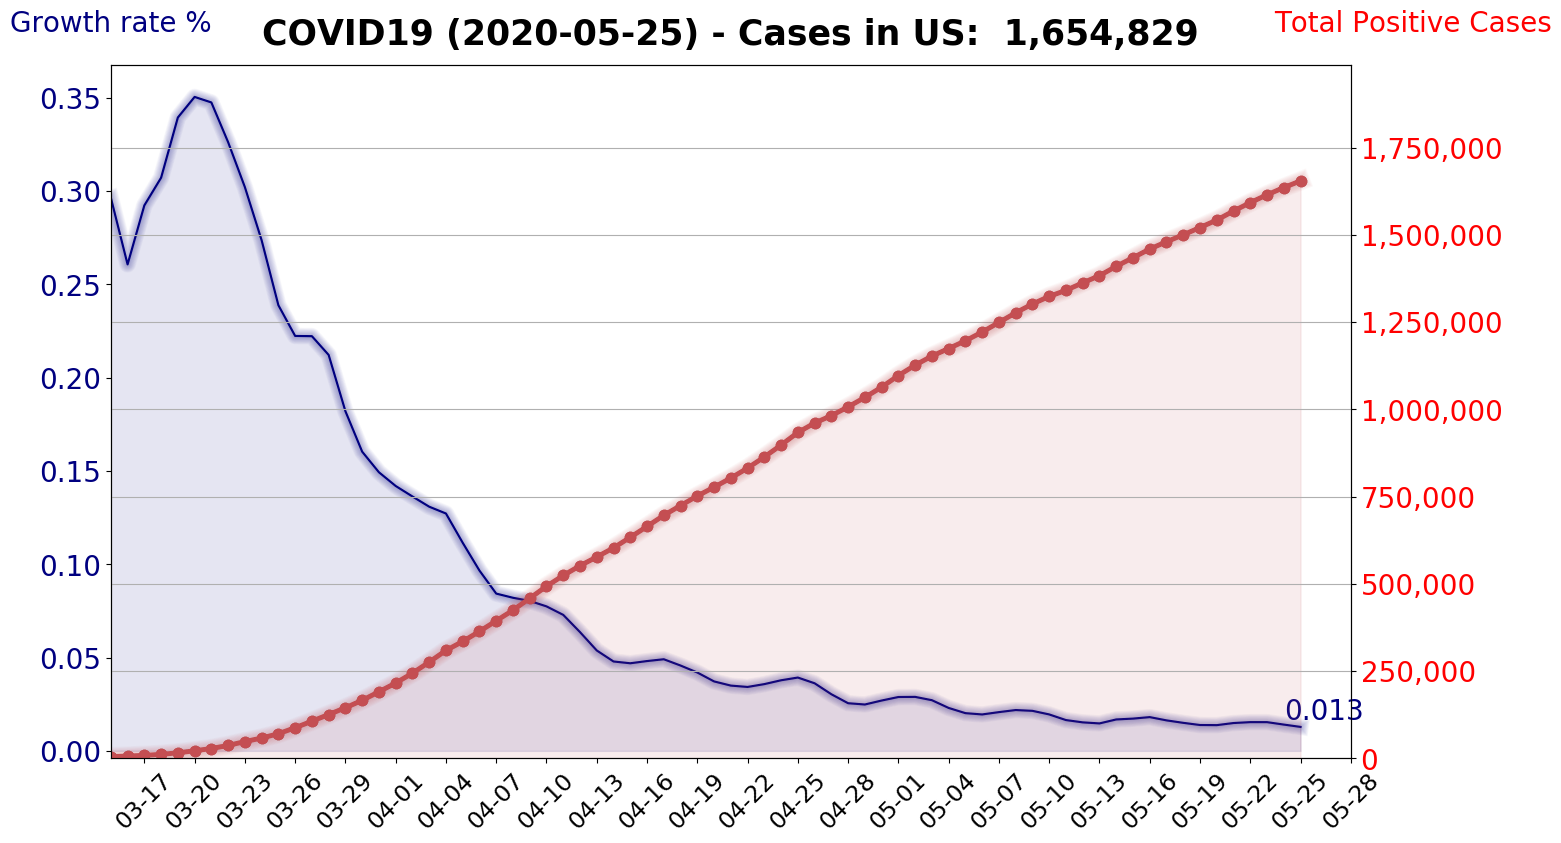

In [55]:
us_cases_ts_gr()

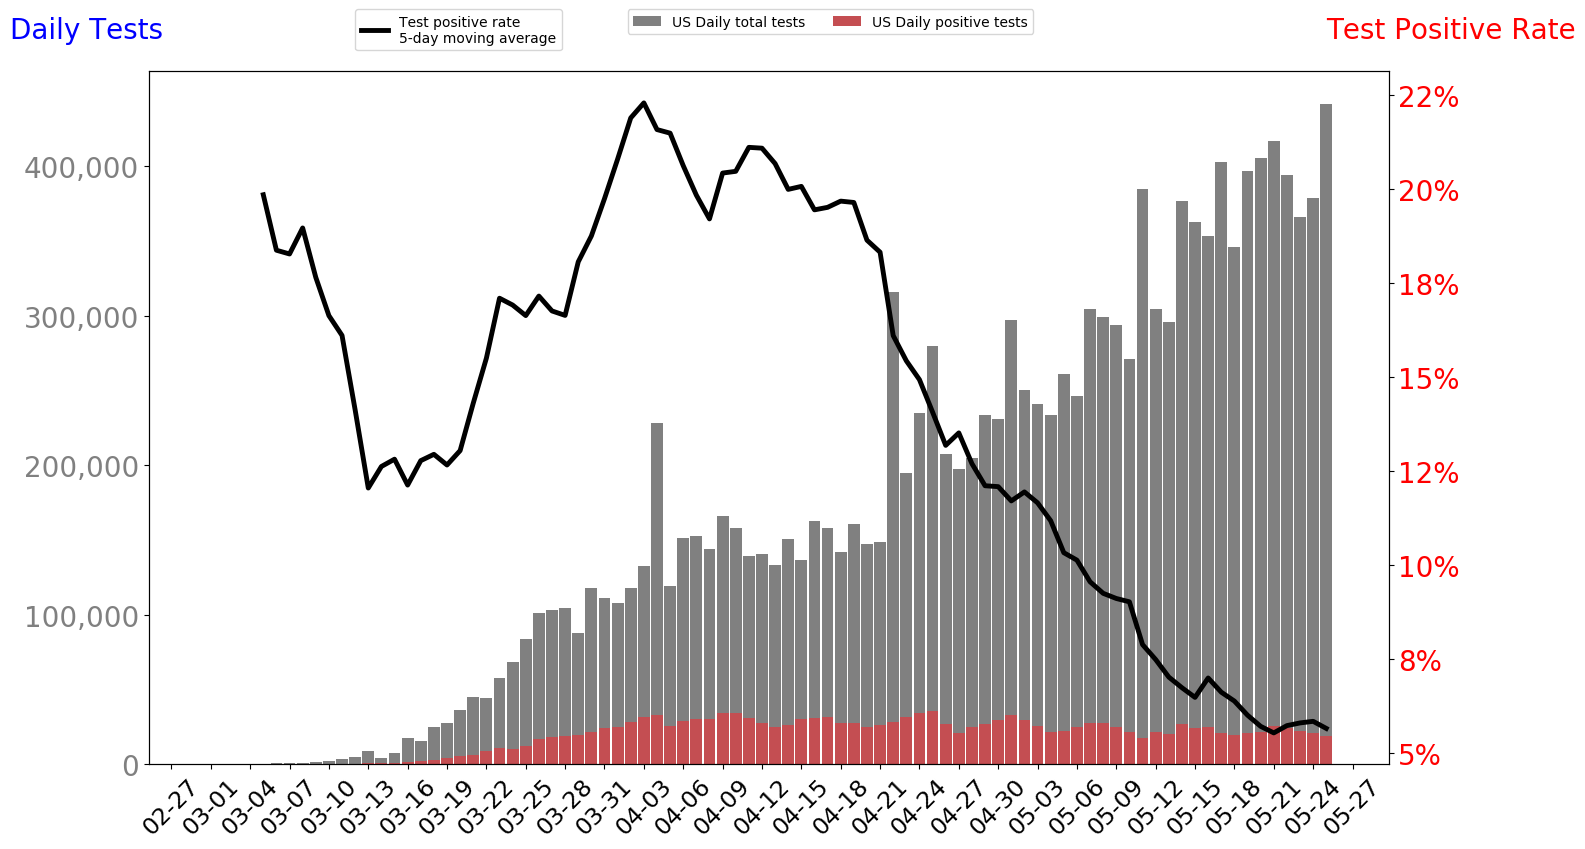

In [56]:
test_positive_rate_plot()

In [57]:
usa_worst_s = usa_covid19.groupby('state').first()[['positive']].sort_values(by='positive',ascending=False)
usa_worst_s['Label'] = usa_worst_s.index + "\n" + usa_worst_s['positive']\
.apply(lambda x : "{:,}".format(x))

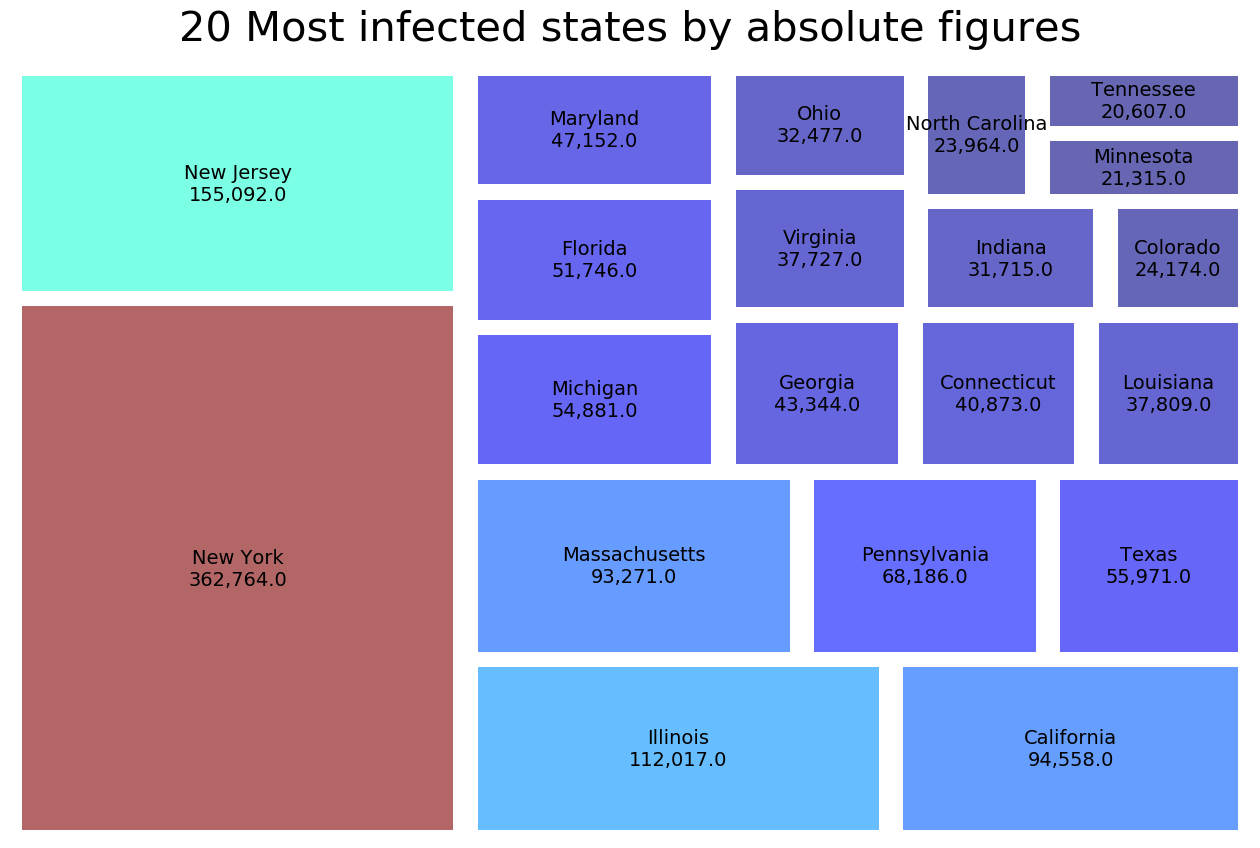

In [58]:
plot_20cq(by='us_worst_cases', boxes=20)

In [59]:
usa_t5 = pd.DataFrame(usa_covid19[usa_covid19['date'] > '2020-03-01'].pivot_table(index='date',values='positive',
          columns=['state'])[-1:].T).nlargest(5,usa_covid19.date[1])
usa_t5.columns=['TotalCases']
usa_t5

TotalCases
state                    
New York         362764.0
New Jersey       155092.0
Illinois         112017.0
California        94558.0
Massachusetts     93271.0

In [60]:
plt.style.use('default')

In [61]:
test = usa_covid19[(usa_covid19['date'] > '2020-03-01') & (usa_covid19['state'].isin(usa_t5.index.tolist()))].pivot_table\
            (index='date',values='positive', columns='state')

### Total cumulative cases as a percentage of the state population

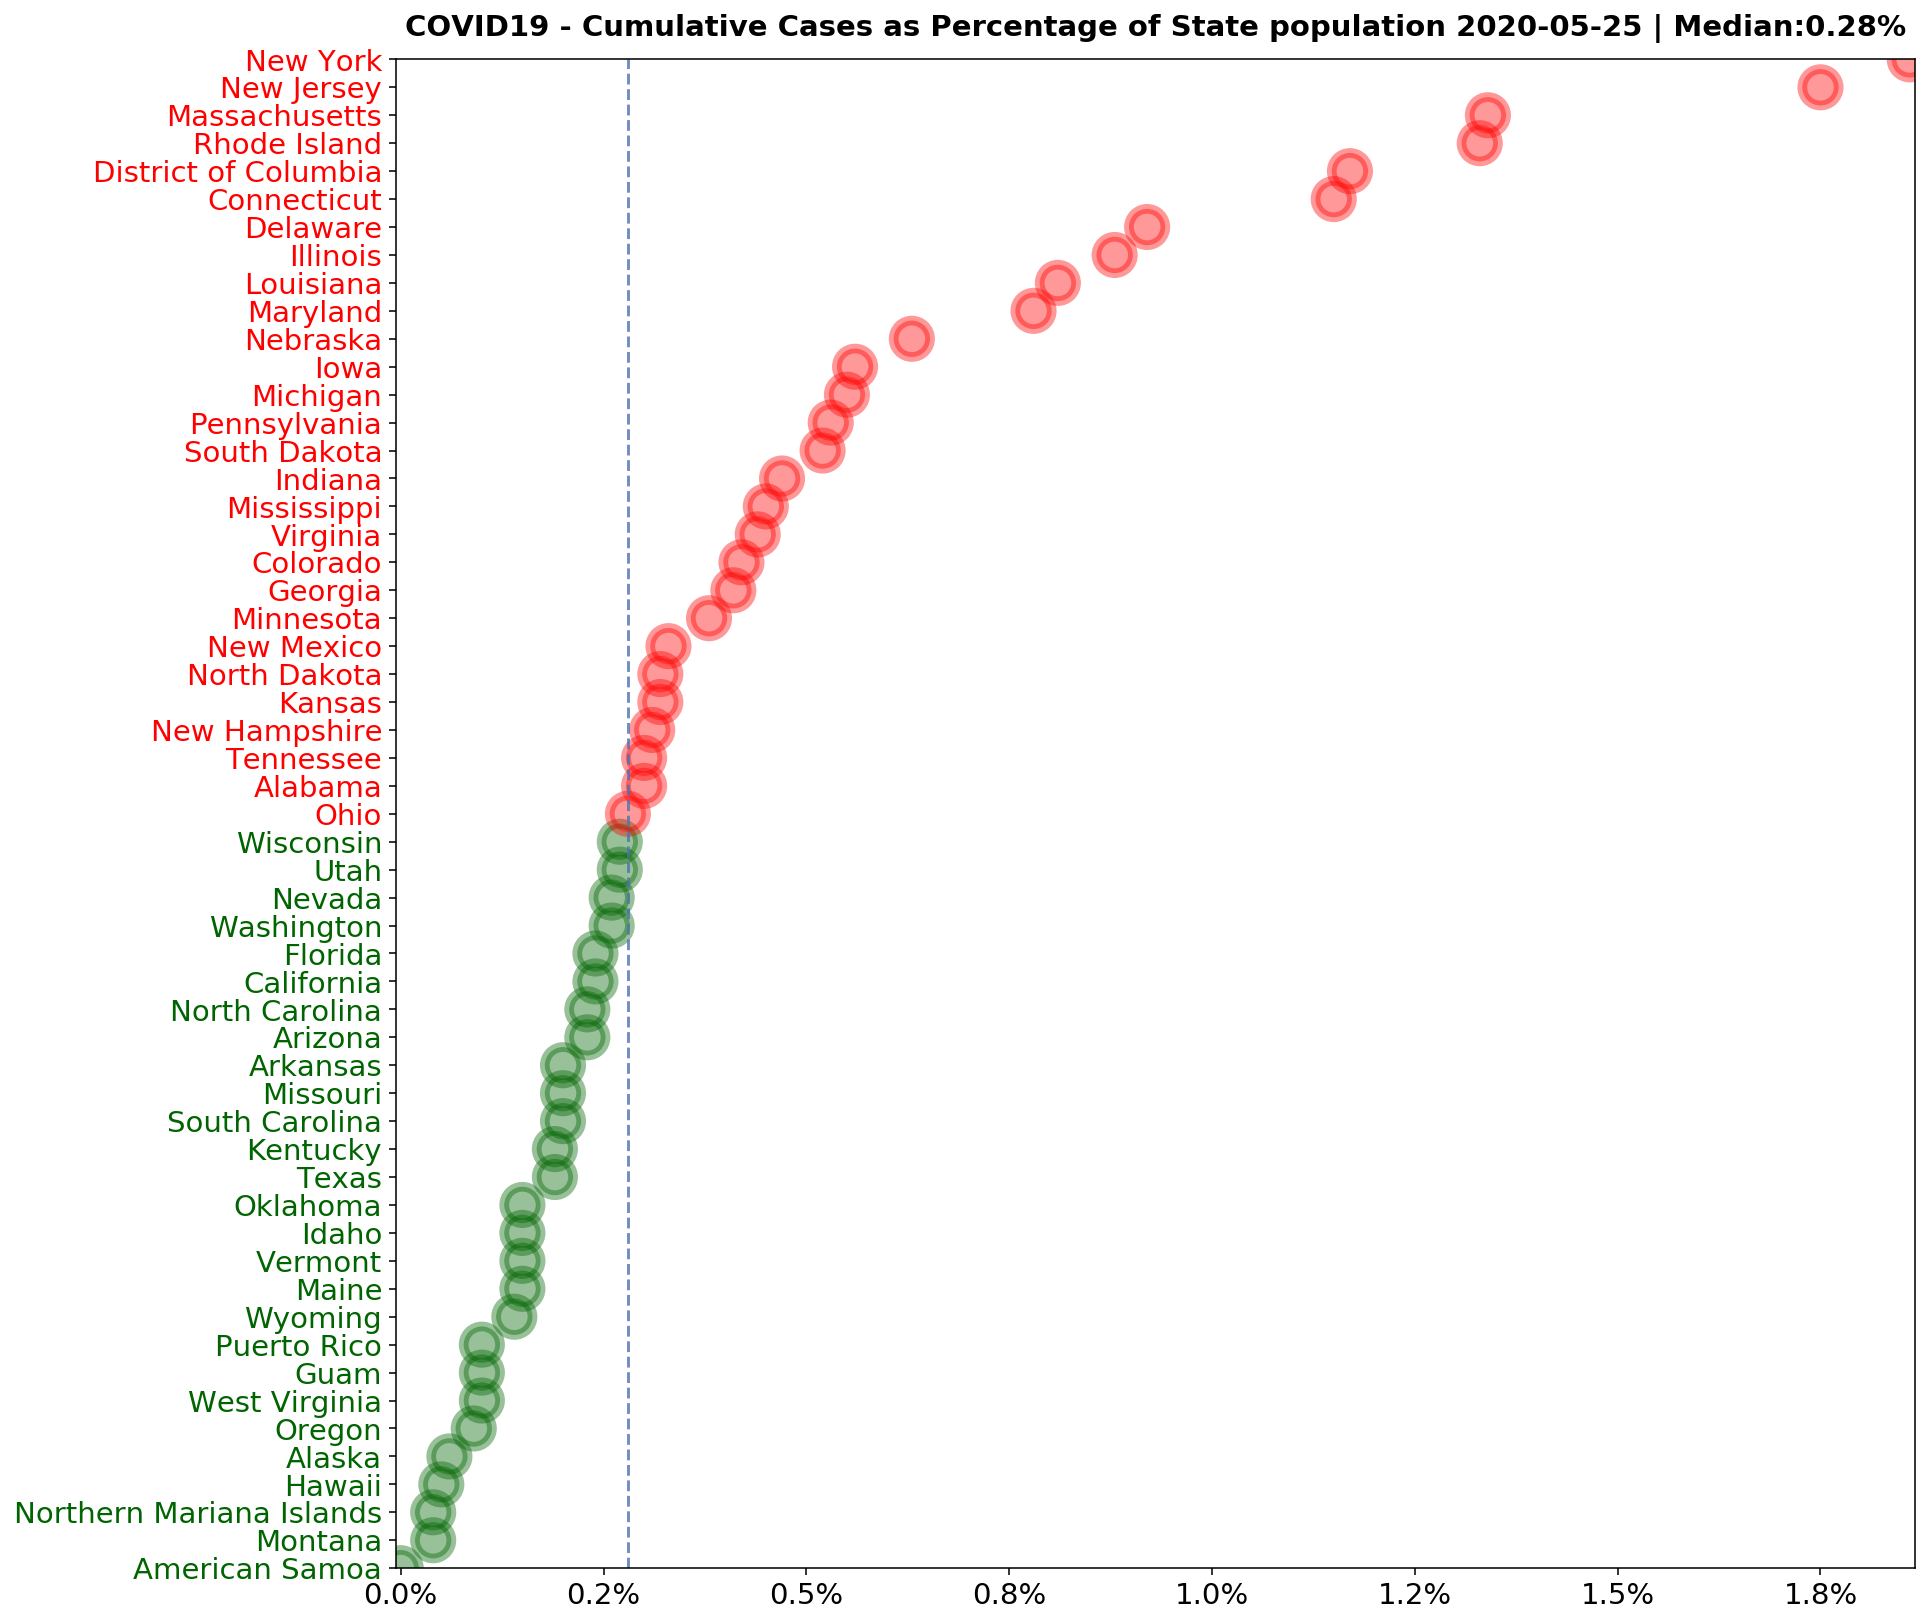

In [63]:
# get states population
a = pd.read_html('https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population')[0]
b  = a[['State', 'Population estimate, July 1, 2019[2]']].rename(columns={'State':'state'})
# merge to main dataset
usa_p = pd.merge(usa_covid19.groupby('state').first(), b, left_index=True, right_on='state')
usa_p.set_index('state', inplace=True)
# plot
plt.style.use('default')
plt.style.use('seaborn-deep')
plt.figure(figsize=(14,14), dpi= 140)
df_pct_p_usa = round(usa_p['positive'] / usa_p['Population estimate, July 1, 2019[2]']*100,2).sort_values()
df_pct_color = ['darkgreen' if x < df_pct_p_usa.median() else 'red' for x in df_pct_p_usa]
plt.scatter(x=df_pct_p_usa, y=df_pct_p_usa.index,s=350, alpha=0.4, linewidth=5, color=df_pct_color)
plt.ylabel(''); plt.xticks(fontsize=15); plt.yticks(fontsize=15);
plt.margins(0)
[ticklabel.set_color(tickcolor) for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), df_pct_color)]
plt.title(f'COVID19 - Cumulative Cases as Percentage of State population '\
          f'{usa_p.date[0].date()} | Median:{df_pct_p_usa.median()}%',
          fontsize=15,pad=12,weight ='semibold');
plt.axvline(df_pct_p_usa.median(), linestyle='--', c='b', alpha=0.8);
plt.gca().set_xticklabels(['{:.1f}%'.format(x) for x in plt.gca().get_xticks()]);

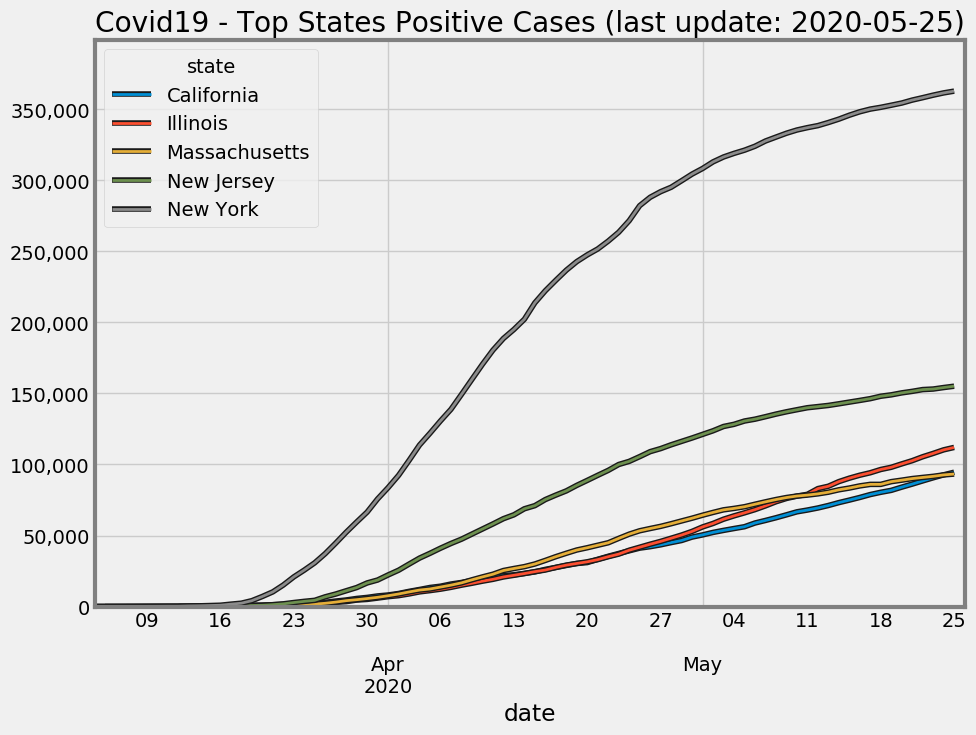

In [64]:
plt.style.use('fivethirtyeight')

usa_tspc = usa_covid19[(usa_covid19['date'] > '2020-02-01') & (usa_covid19['state'].isin(usa_t5.index.tolist()))].pivot_table\
           (index='date',values='positive', columns='state')
ax = usa_tspc.plot(figsize=(10,7), lw=2,path_effects=[path_effects.Stroke(linewidth=4, foreground='k'), path_effects.Normal()])
plt.title(f'Covid19 - Top States Positive Cases (last update: {usa_covid19.date[0].date()})');
plt.xlim(usa_tspc.index.min(), usa_tspc.index.max() + datetime.timedelta(1))
plt.ylim(0,usa_tspc.max().max()*1.1)

ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))); 
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')

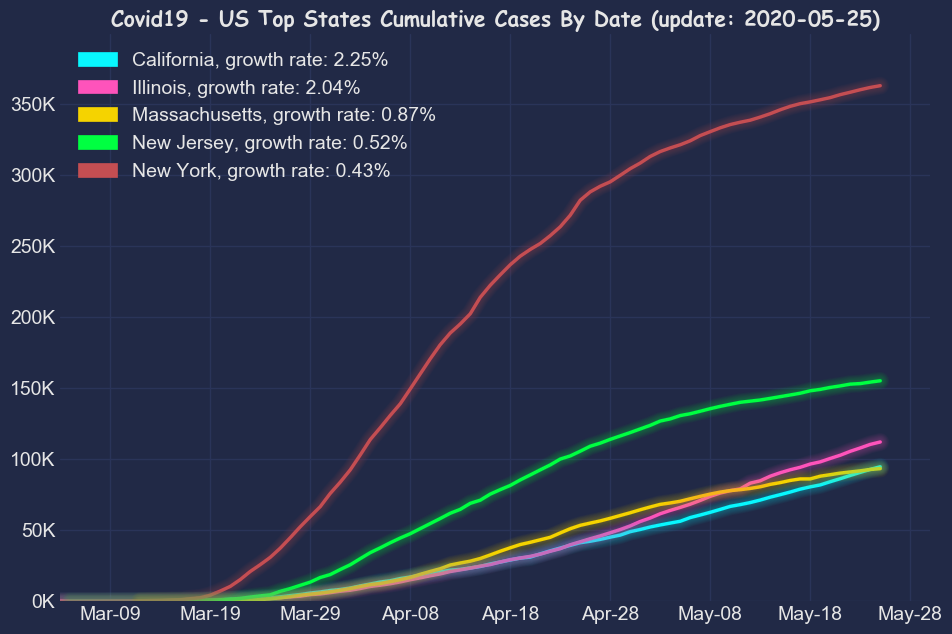

In [65]:
us_top5_s_cumulative()

### Top States Daily Positive Cases

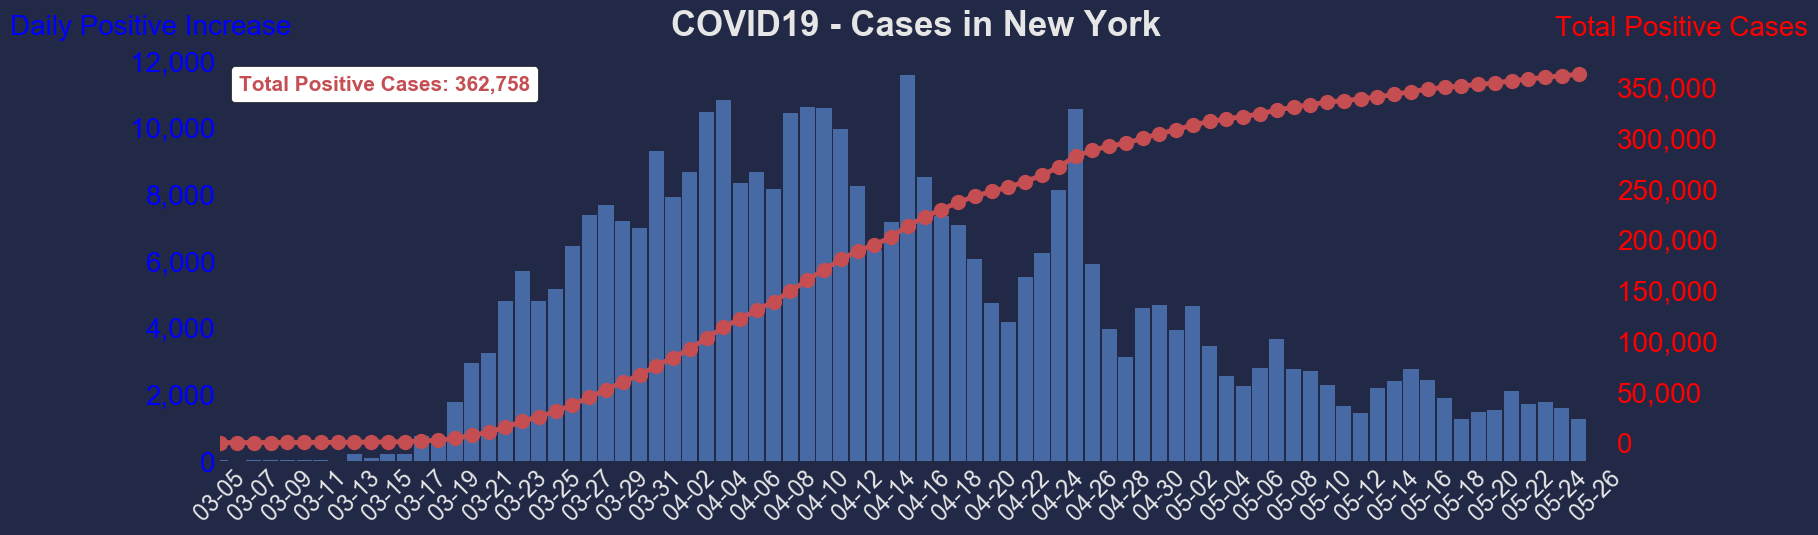

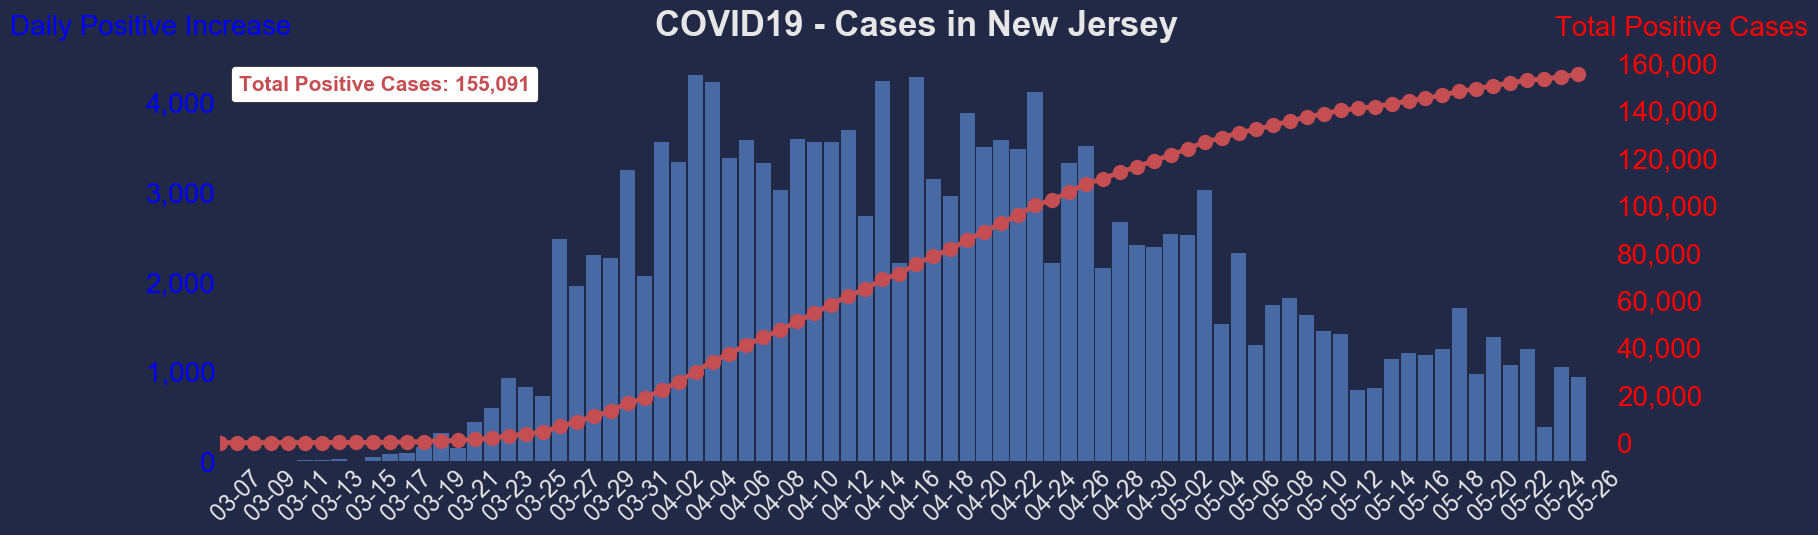

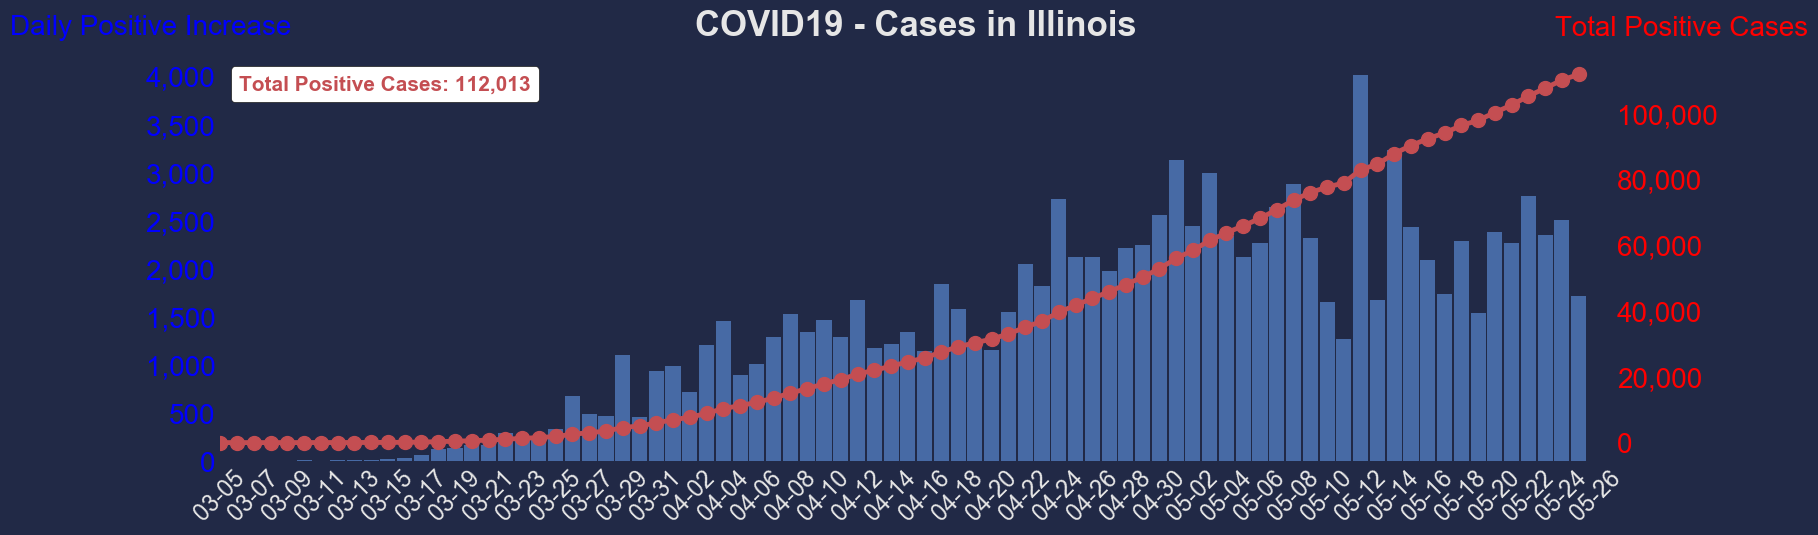

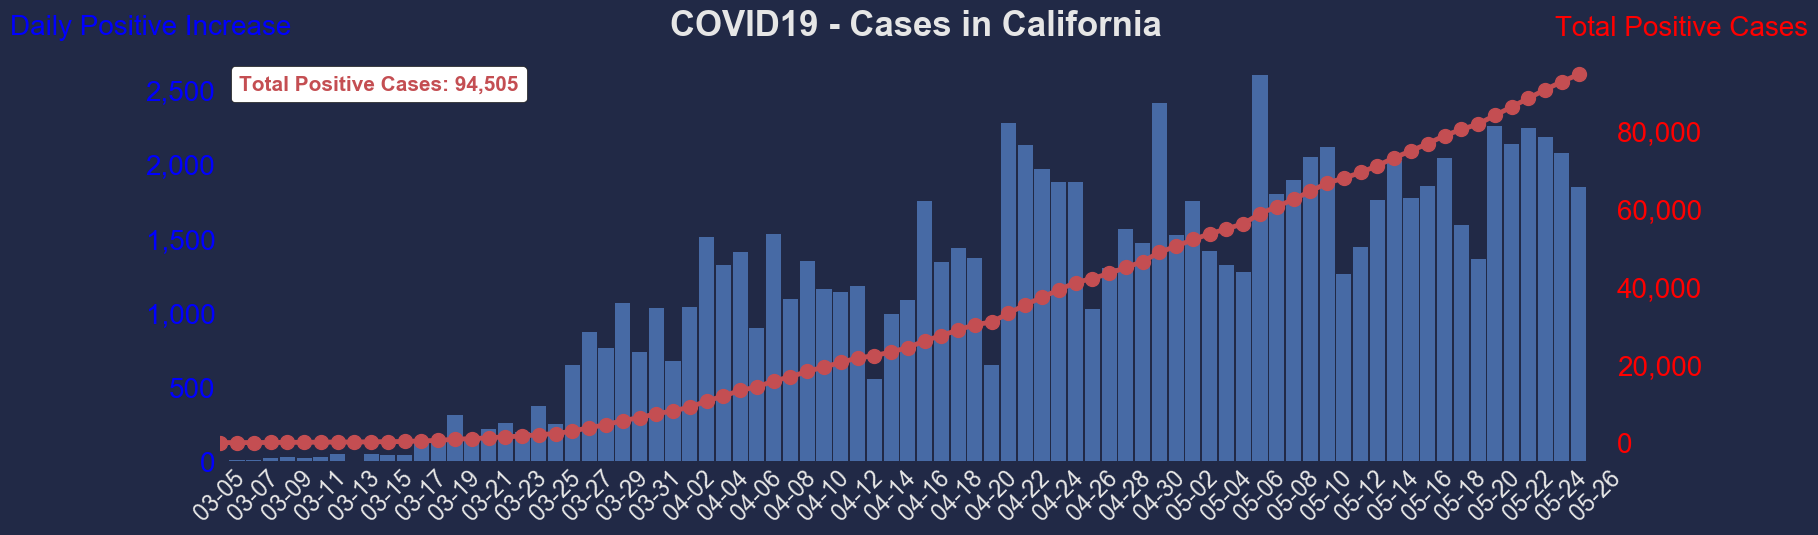

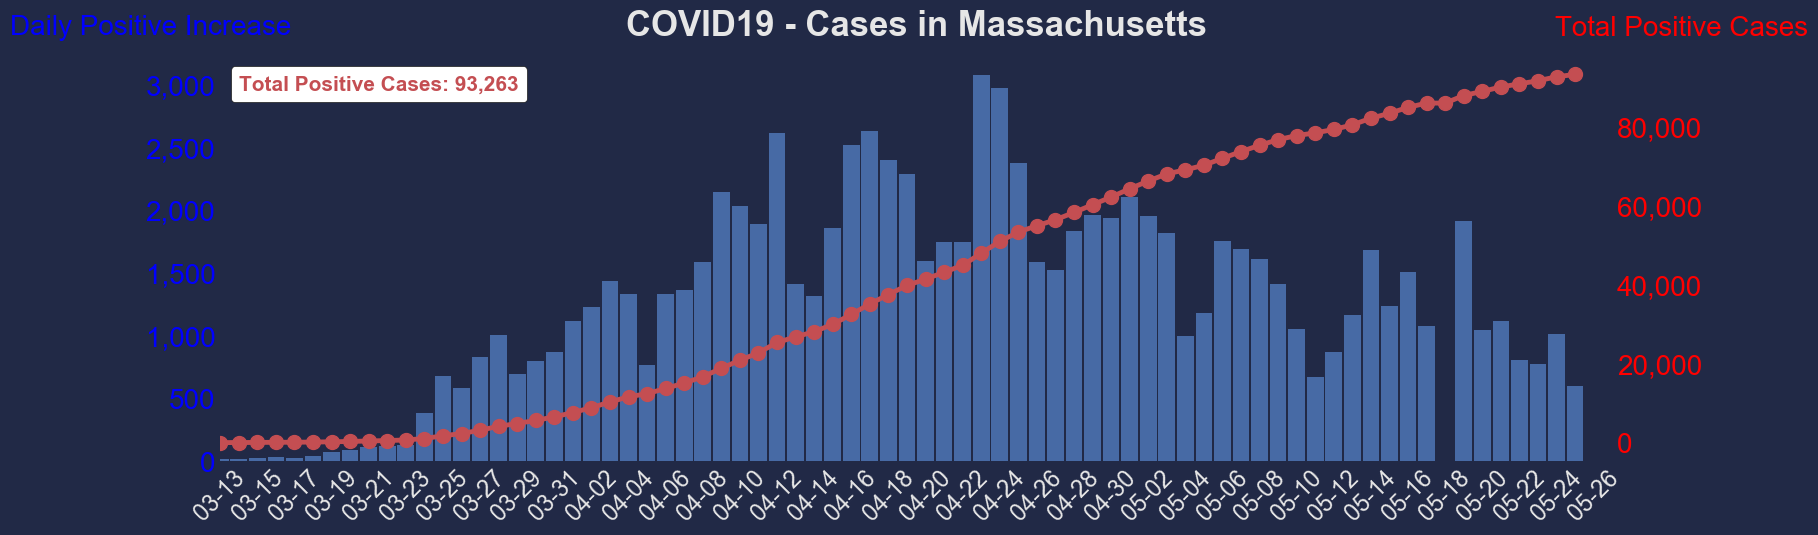

In [66]:
for state in usa_t5.index:
    
    positive_cases_plot(usa_covid19,state)

## Let's see, in a time series pivot table, the percentage of each state of the total US cases.

In [67]:
# time series pivot table, the percentage of each state of the total US cases.
ap = usa_covid19[(usa_covid19['date'] > '2020-04-01') ]\
    .pivot_table(index='date',values='positive', columns='state')
ap = (ap.T/ap.T.sum()*100).T.round(2).T
ap = ap[ap.iloc[:,-1]>1]

ap.iloc[:, ::3]

date            2020-04-02  2020-04-05  2020-04-08  2020-04-11  2020-04-14  \
state                                                                        
California            3.76        4.01        3.99        3.93        3.87   
Colorado              1.37        1.36        1.28        1.24        1.27   
Connecticut           1.57        1.69        1.83        2.20        2.32   
Florida               3.28        3.63        3.64        3.53        3.54   
Georgia               2.19        1.98        2.33        2.32        2.36   
Illinois              3.15        3.36        3.55        3.66        3.85   
Indiana               1.24        1.32        1.40        1.42        1.41   
Iowa                  0.25        0.26        0.27        0.29        0.31   
Louisiana             3.75        3.88        4.01        3.82        3.57   
Maryland              0.95        1.08        1.30        1.47        1.57   
Massachusetts         3.63        3.70        3.93        4.34        4.66   
Michigan              5.78        5.24        4.85        4.58        4.48   
Minnesota             0.30        0.28        0.27        0.27        0.28   
New Jersey           10.48       11.19       11.17       11.09       11.41   
New York             37.84       36.41       35.17       34.42       33.52   
North Carolina        0.76        0.77        0.81        0.82        0.83   
Ohio                  1.19        1.21        1.21        1.19        1.21   
Pennsylvania          2.87        3.43        3.83        4.13        4.20   
Tennessee             1.17        1.08        1.03        0.98        0.97   
Texas                 1.91        2.03        2.20        2.40        2.42   
Virginia              0.70        0.79        0.86        0.97        1.02   
Washington            3.18        2.55        2.28        2.00        1.86   

date            2020-04-17  2020-04-20  2020-04-23  2020-04-26  2020-04-29  \
state                                                                        
California            3.95        3.99        4.33        4.39        4.50   
Colorado              1.25        1.25        1.26        1.35        1.42   
Connecticut           2.41        2.55        2.67        2.63        2.59   
Florida               3.46        3.43        3.34        3.28        3.21   
Georgia               2.47        2.44        2.49        2.43        2.47   
Illinois              3.96        4.05        4.28        4.57        4.87   
Indiana               1.46        1.50        1.51        1.56        1.66   
Iowa                  0.33        0.41        0.45        0.57        0.66   
Louisiana             3.32        3.15        2.98        2.79        2.67   
Maryland              1.66        1.76        1.82        1.93        2.02   
Massachusetts         5.04        5.33        5.56        5.72        5.83   
Michigan              4.31        4.12        4.09        3.93        3.91   
Minnesota             0.30        0.32        0.34        0.37        0.45   
New Jersey           11.26       11.43       11.58       11.35       11.24   
New York             32.97       31.84       30.50       29.97       28.97   
North Carolina        0.84        0.87        0.88        0.92        0.96   
Ohio                  1.31        1.66        1.70        1.66        1.67   
Pennsylvania          4.23        4.28        4.29        4.28        4.29   
Tennessee             0.95        0.93        0.96        1.01        1.00   
Texas                 2.49        2.50        2.54        2.56        2.62   
Virginia              1.08        1.16        1.27        1.35        1.45   
Washington            1.75        1.65        1.57        1.48        1.46   

date            2020-05-02  2020-05-05  2020-05-08  2020-05-11  2020-05-14  \
state                                                                        
California            4.63        4.70        4.90        5.07        5.19   
Colorado            

In [68]:
usa_covid19lw = usa_covid19[usa_covid19['date'] < (usa_covid19.date.max()-datetime.timedelta(6))]
usa_top10 = usa_covid19.groupby('state')[['positive']].first().sort_values(by='positive').reset_index()[-20:]
usa_top20 = usa_covid19.groupby('state')[['positive']].first().sort_values(by='positive').reset_index()[-20:]

print('* Replace nan with 0 for missing values in the recovered column');
usa_covid19.groupby('state')[['positive','death','recovered']].first().sort_values(by='positive', ascending=False)\
.fillna(0).style.format({'positive':'{:,.0f}', 'death':'{:,.0f}', 'recovered':'{:,.0f}'})\
.background_gradient(cmap='Blues',subset=["positive"])\
.background_gradient(cmap='OrRd',subset=["death"])\
.background_gradient(cmap='Greens',subset=["recovered"])\
.set_caption('US states')


* Replace nan with 0 for missing values in the recovered column


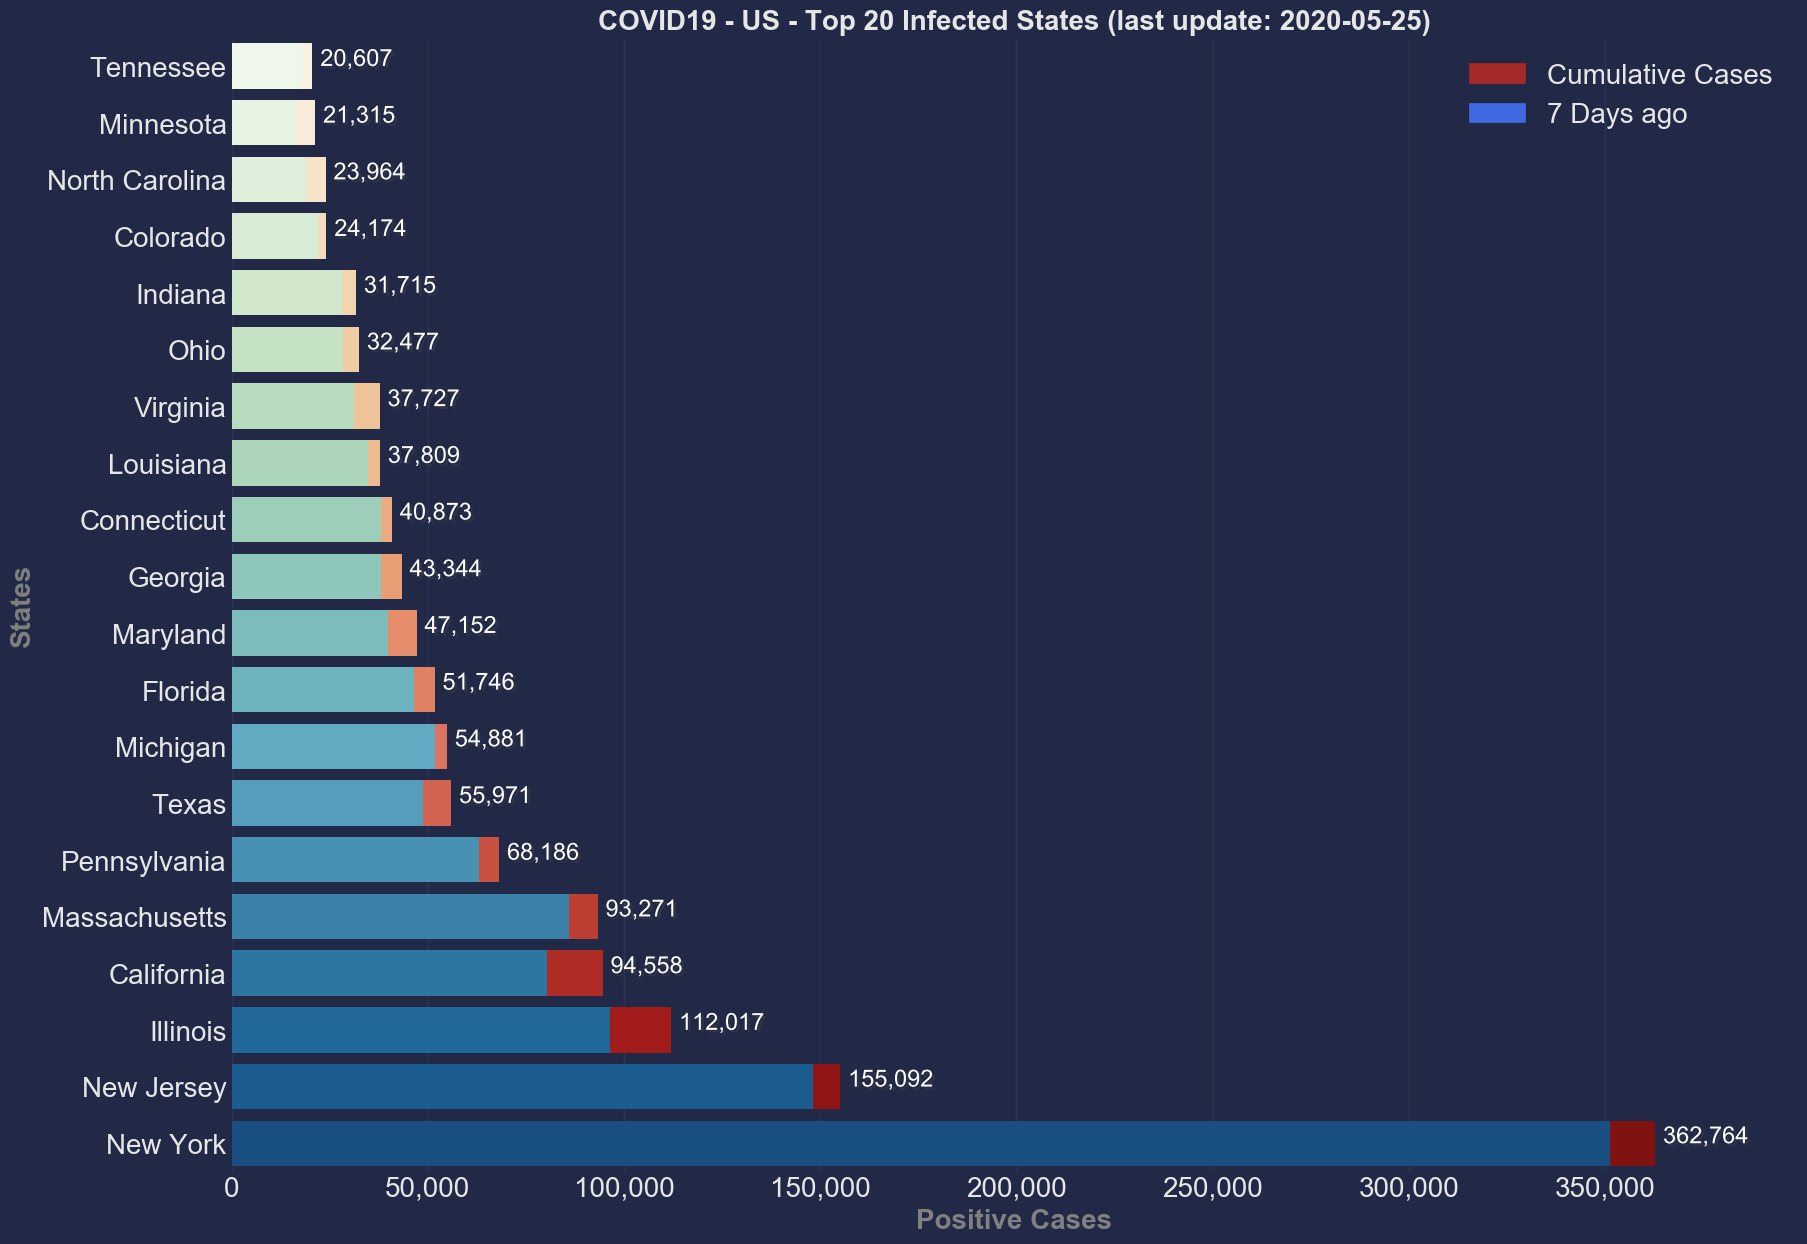

In [69]:
top_20_infected()

<b>And, Let's see the states with the highest rate of change for the last 7 days:</b>

In [70]:
usa_w_roc = usa_covid19.groupby('state')[['positive']].first()
usa_w_roc['weekly change'] = usa_covid19.groupby('state')[['positive']].first() - usa_covid19lw.groupby('state')\
                             [['positive']].first()
usa_w_roc['% change']  = (usa_covid19.groupby('state')[['positive']].first() / usa_covid19lw.groupby('state')[['positive']]\
                         .first()-1)
usa_w_roc = usa_w_roc.sort_values(by='% change', ascending=False).head(10)
usa_w_roc.style.format({'positive':'{:,.0f}', 'weekly change':'{:,.0f}','% change':'{:.01%}'}).background_gradient(cmap='Blues')

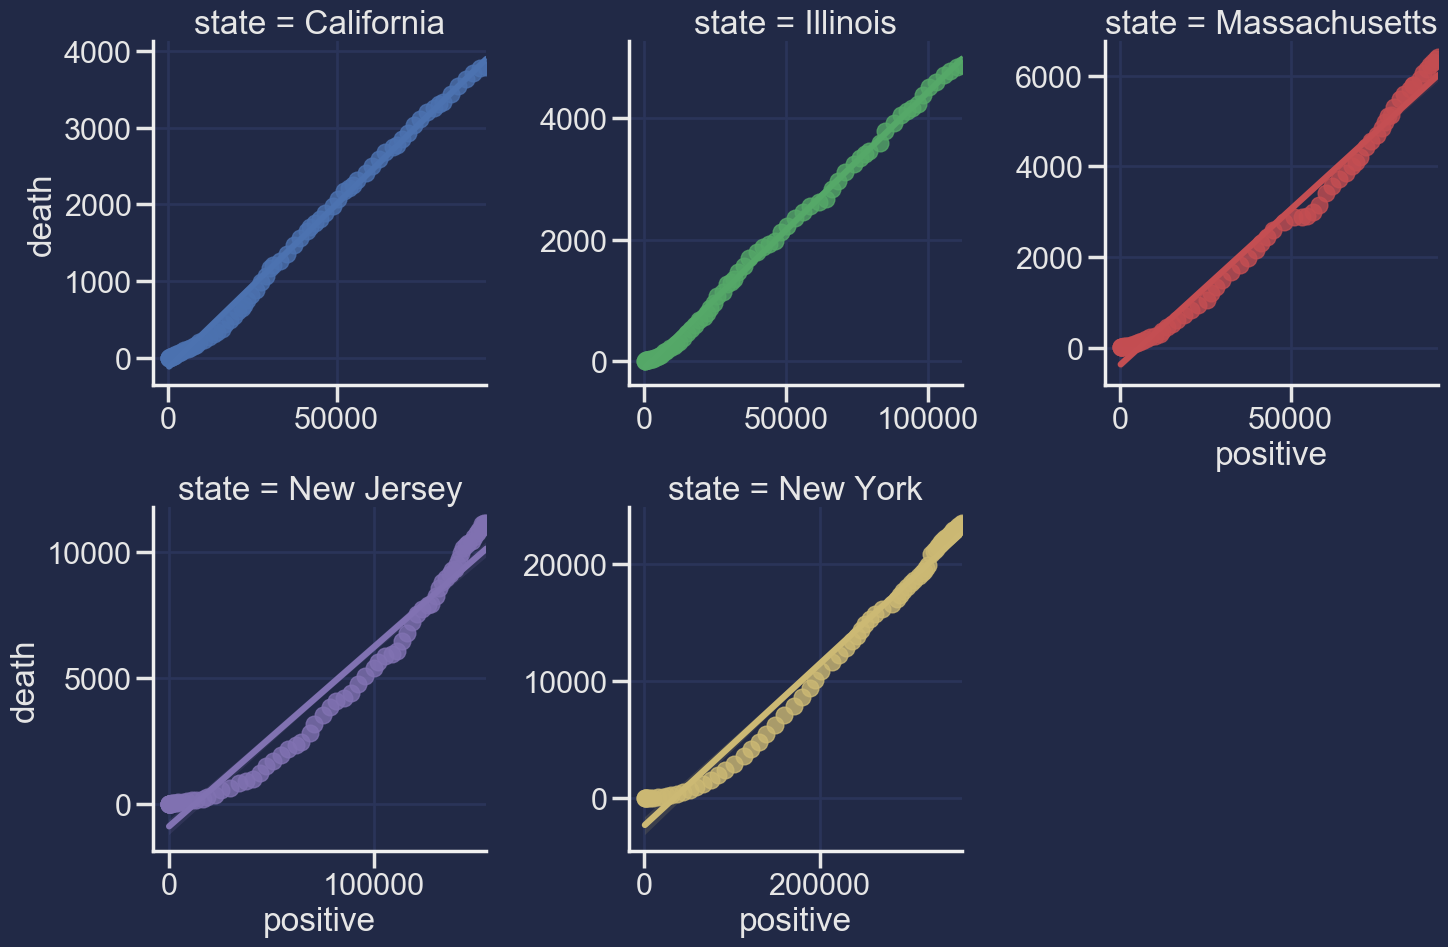

In [71]:
top_us_states_df = usa_covid19[usa_covid19['state'].isin(usa_t5.index.tolist())].copy()

# total deaths to positive cases in each top state
sns.lmplot(x='positive', y='death', col='state', hue='state', col_wrap=3,
           data=top_us_states_df,sharex=False,sharey=False);

![US states](https://assets.weforum.org/article/image/large_kPbdJNerlCdAz-8fizqPQGg3sSSKfnSyJSrstSJTpfY.jpg)    